In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import glob
import os
import peakutils
import datetime
import warnings
import logging
from jupyterthemes import jtplot

In [3]:
from xps.xps_sw import *
from xps.xps_import import *
from xps.xps_analysis import *
from xps.xps_bg import *

jtplot.style('default', grid=False)
logging.getLogger().setLevel(logging.CRITICAL)

plt.rcParams['errorbar.capsize'] = 8
plt.rcParams['font.size'] = 18
plt.rc('font', size= 18)
plt.rc('legend', fontsize= 15)
plt.rc('xtick', labelsize= 18)
plt.rc('ytick', labelsize= 18)
plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

In [4]:
asf = dict({'C_1s' : 0.296, 'O_1s' : 0.711, 'N_1s' : 0.477, 'Ba_3d' : 7.49,
            'Au_4f' : 6.250, 'Cl_2p' : 0.891})

In [4]:
def plot_regions(experiments : list, regions : list, colors : list = None):
    """Subplots all regions of a list of experiments (unnormalised)"""
    rows = int(np.ceil(len(regions) / 3))
    cols = 3
    
    fig, ax = plt.subplots(rows, cols, figsize=(16, 8))
    for i,r in enumerate(regions):
        for c,xp in enumerate(experiments):
            j, k = i//3, i%3            
            if i == len(regions) - 1:   # Set labels from last region
                li = plot_region(xp, r, ax=ax[j][k], lb=xp.name)
                if len(colors) > 0: li.set_color(colors[c])
                ax[j][k].set_title('Au_4f')
                ax[j][k].get_legend().remove()
            else:
                li = plot_region(xp, r, ax=ax[j][k], lb='__nolabel__')
                if len(colors) > 0: li.set_color(colors[c])
                ax[j][k].set_title(r)
            cosmetics_plot(ax=ax[j][k], leg = False);
        if len(experiments)%2 == 0:
            ax[j][k].invert_xaxis()
    plt.tight_layout()
    fig.legend()

## Background subtraction class (dev) 

In [344]:
class Background2(object):
    @staticmethod
    def bg_handler(xp, region,  *args, **kwargs):
        x = xp.dfx[region].dropna().energy.values
        y = xp.dfx[region].dropna().counts.values
        return x, y

    @staticmethod
    def edit_xp(xp, region, x, y, ybg, ax = None):
        if ax == None: ax = plt.gca()
        col = plot_region(xp, region, lb=region, ax=ax).get_color()
        ax.plot(x, ybg, '--', color=col, label='__nolabel__')
        cosmetics_plot(ax=ax)
        
        dfnew = pd.DataFrame({'energy' : x, 'counts' : y - ybg})
        xpNew = deepcopy(xp)
        xpNew.dfx[region] = dfnew
        return xpNew

    def dec_linear(self, xp, region, *args, **kwargs):
        x, y = self.bg_handler(xp, region, *args, **kwargs)

        ybg = peakutils.baseline(y, deg=1)
        return self.edit_xp(xp, region, x, y, ybg)
    
    def dec_shirley(self, xp, region, maxit=40, **kwargs):
        kwargs['maxit'] = maxit
        x,y = self.bg_handler(xp, region, **kwargs)
        ybg = shirley_loop(x,y, **kwargs)
        return self.edit_xp(xp, region, x, y, ybg)
    
    def dec_2shirley(self, xp, region, xlim, maxit=40, **kwargs):
        x, y = self.bg_handler(xp, region, **kwargs)
        y1 = y[ x >= xlim ]
        x1 = x[ x >= xlim ]
        y2 = y[ x <= xlim ]
        x2 = x[ x <= xlim ]

        ybg1 = shirley_loop(x1, y1, maxit = maxit)#, flag_plot=flag_plot, ax = ax)
        ybg2 = shirley_loop(x2, y2, maxit = maxit)#, flag_plot=flag_plot, ax = ax)
        ybg = np.append(np.append(ybg1[:-1], np.average([ybg1[-1], ybg2[0]])), ybg2[1:] )
        return self.edit_xp(xp, region, x, y, ybg, **kwargs)

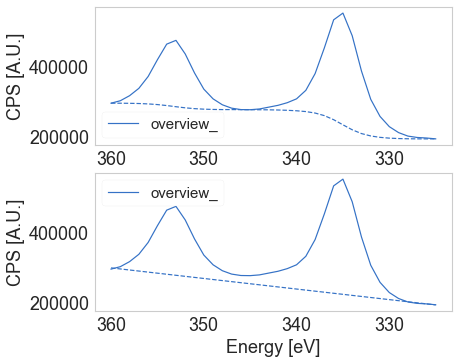

In [345]:
# Background2().dec_linear(xp=experiments[0], region='C_1s')
fig, ax = plt.subplots(2)
BG2 = Background2()
bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                       xlim = 346, maxit=50, ax=ax[0])
bg2 = BG2.dec_linear(xp=trim_exps[0], 
                     region='overview_', ax=ax[1])

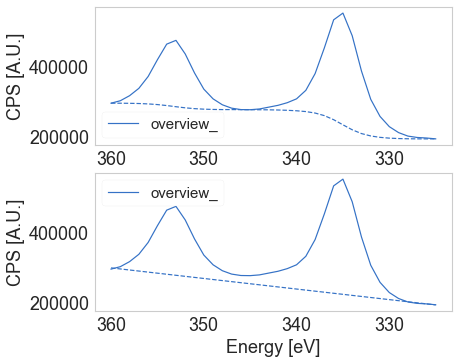

In [346]:
def test_bg_subpots()
    fig, ax = plt.subplots(2)
    BG2 = Background2()
    bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                           xlim = 346, maxit=50, ax=ax[0])
    bglin = BG2.dec_linear(xp=trim_exps[0], 
                         region='overview_', ax=ax[1])

    assert len(ax[0].get_lines()) <= 2, "Too many lines in lin_bg subplot"
    assert len(ax[0].get_lines()) >= 2, "Not enough lines in lin_bg subplot"

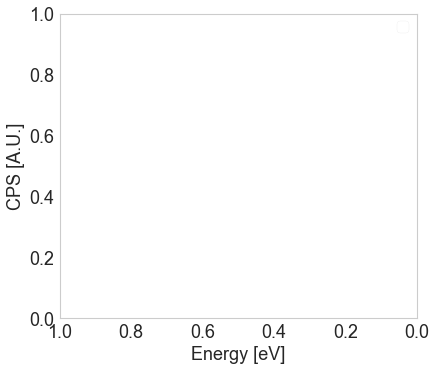

In [360]:
BG2 = Background2()
bg2 = BG2.dec_2shirley(xp=trim_exps[0], region='overview_', 
                       xlim = 346, maxit=50, ax=ax[0])
x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
x,ybg = BG2.bg_handler(bg2, region='overview_')
lentest = len(np.where(y < ybg)[0])
assert lentest == 0, "Background over signal in %i points"%lentest


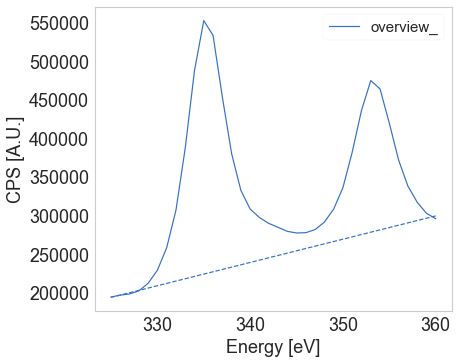

In [361]:
BG2 = Background2()
bg2 = BG2.dec_linear(xp=trim_exps[0], region='overview_')
x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
x,ybg = BG2.bg_handler(bg2, region='overview_')
lentest = len(np.where(y < ybg)[0])
assert lentest == 0, "Background over signal in %i points"%lentest


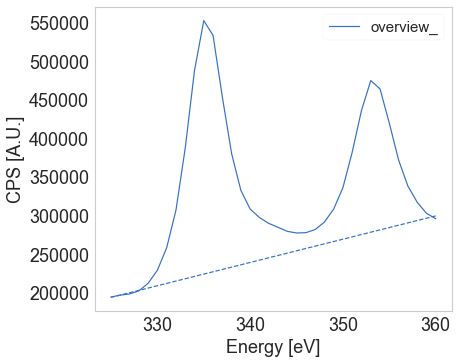

In [364]:
def test_method(method):
    BG2 = Background2()
    bg2 = method(xp=trim_exps[0], region='overview_')
    x,y = BG2.bg_handler(xp=trim_exps[0], region='overview_')
    x,ybg = BG2.bg_handler(bg2, region='overview_')
    lentest = len(np.where(y < ybg)[0])
    assert lentest == 0, "Background over signal in %i points"%lentest
test_method(Background2().dec_linear)

## Pre-processing of data FBI-Ba++ on Au(788)
1- ALI injections 800 mbar, 1 µM (16-17.10.2019)

2- ALI injections 200 mbar, 1 µM (23-25.10.2019)

3- Dropcast 1 mM (28-30.10.2019)

# ALI injections 800 mbar
40, 80 and 120 pulses

At $t_{on}$ = 50 ms and C = 1µM

## Import data

In [6]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/**/*.xy'
files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if (' ' not in f) and ('/proc' not in f):
        files_new.append(f)
files = files_new[2:6]
files[2], files[3] = files[3], files[2]
for f in files:
    print(os.path.split(f)[1])

20191016_Au(788)_clean.xy
20191016_FBI_FBI_Ba_1uM_40pulse_50ms_Au(788).xy
20191017_FBI_FBI_Ba_1uM_80pulse_50ms_Au(788).xy
20191017_FBI_FBI_Ba_1uM_120pulse_50ms_Au(788).xy


In [15]:
names = ['au_clean', '40pulses_800mbar', '80pulses_800mbar', '120pulses_800mbar']
label = ['Au(788) clean', 'FBI-Ba 40pulses, 800mbar GAr', 'FBI-Ba 80pulses, 800mbar GAr', 'FBI-Ba 120pulses, 800mbar GAr']

experiments = [xps_data_import(path=f, name=n, label=l) for f,n,l in zip(files, names, label)]
experiments[1].name

'40pulses_800mbar'

## Bg subtraction

In [215]:
region = 'overview_'

Text(0.5, 1.0, 'Au 4f')

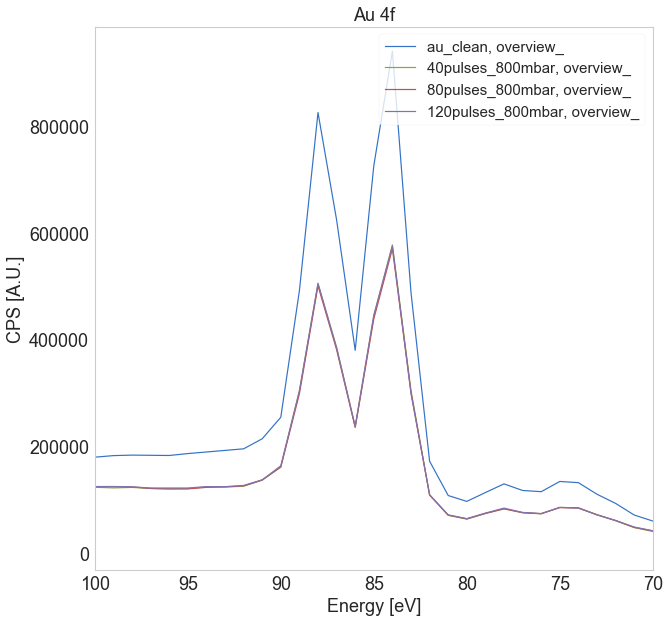

In [168]:
plt.figure(figsize=(10,10))
for xp in experiments:
    plot_region(xp, 'overview_')
plt.xlim(70, 100)
# plt.ylim(1.5e5, 4e5)
cosmetics_plot()
plt.title('Au 4f')

Text(0.5, 1.0, 'Au 4d')

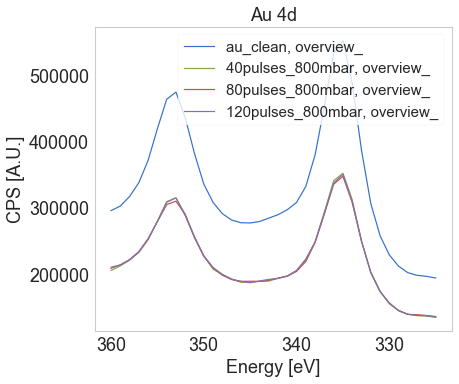

In [216]:
trim_exps = []
for xp in experiments:
    xp_new = crop_spectrum(xp, region=region, eup=360, edw=325)
    trim_exps.append(xp_new)
    plot_region(xp_new, region)
cosmetics_plot()
plt.title('Au 4d')

### Subtract double shirley to all Au regions

In [172]:
region = 'overview_'

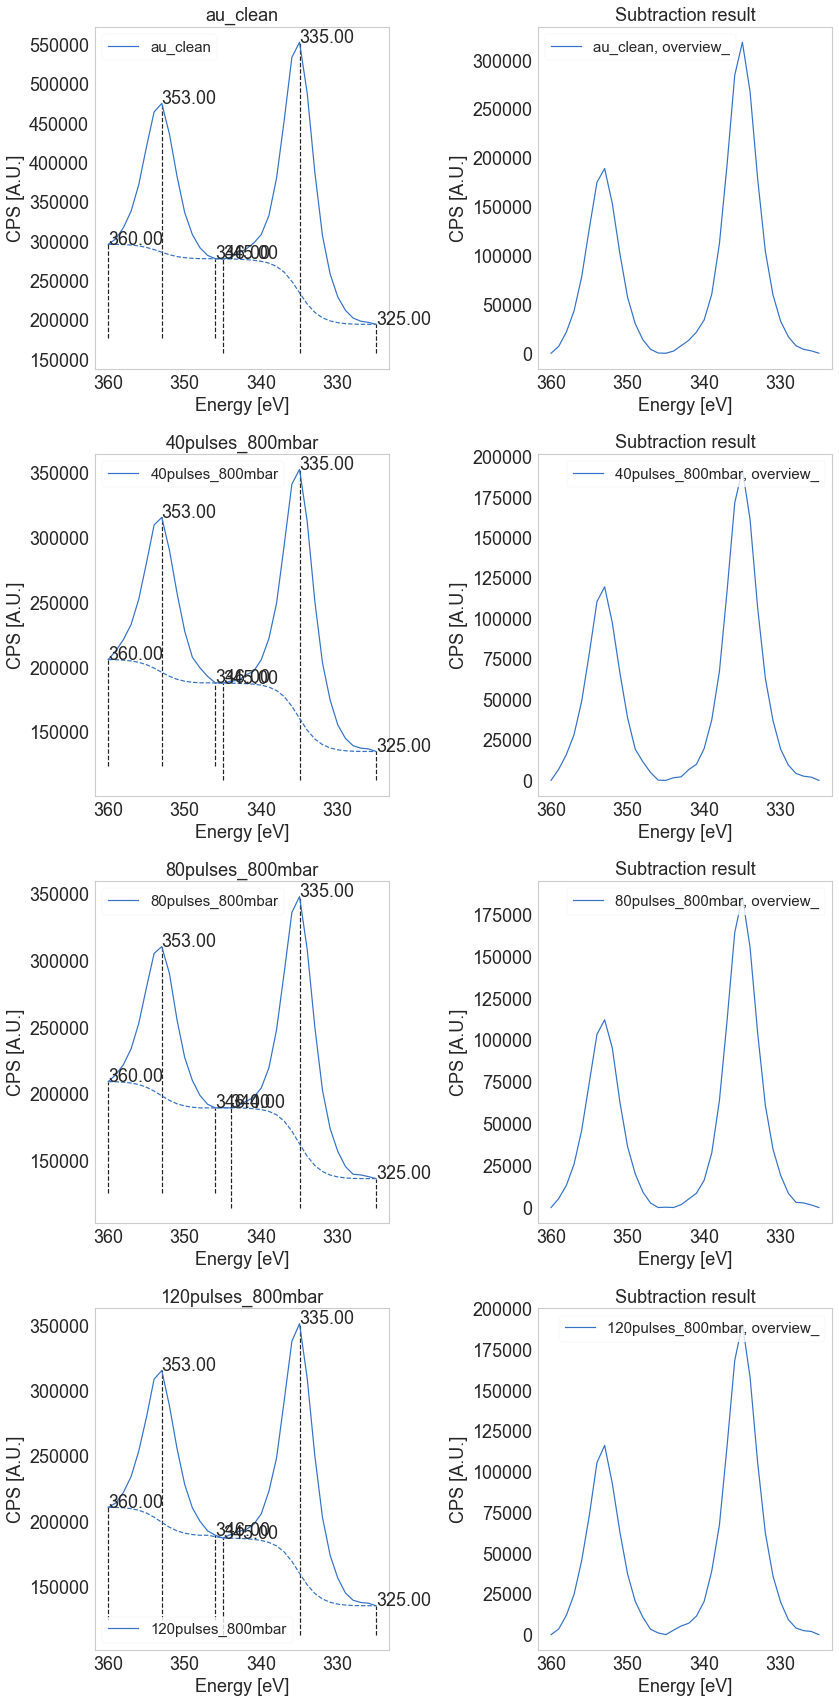

In [173]:
bg_exps = region_2bg_subtract(trim_exps, region=region, xlim=346)

In [159]:
[xp.dfx.columns.levels[0] for xp in trim_exps]

[Index(['Ba_3d', 'C_1s', 'Cl_2p', 'N_1s', 'O_1s', 'overview_'], dtype='object'),
 Index(['Ba_3d', 'C_1s', 'Cl_2p', 'N_1s', 'O_1s', 'overview_'], dtype='object'),
 Index(['Ba_3d', 'C_1s', 'Cl_2p', 'N_1s', 'O_1s', 'overview_'], dtype='object'),
 Index(['Ba_3d', 'C_1s', 'Cl_2p', 'N_1s', 'O_1s', 'overview_'], dtype='object')]

### Bulk subtract background

Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline


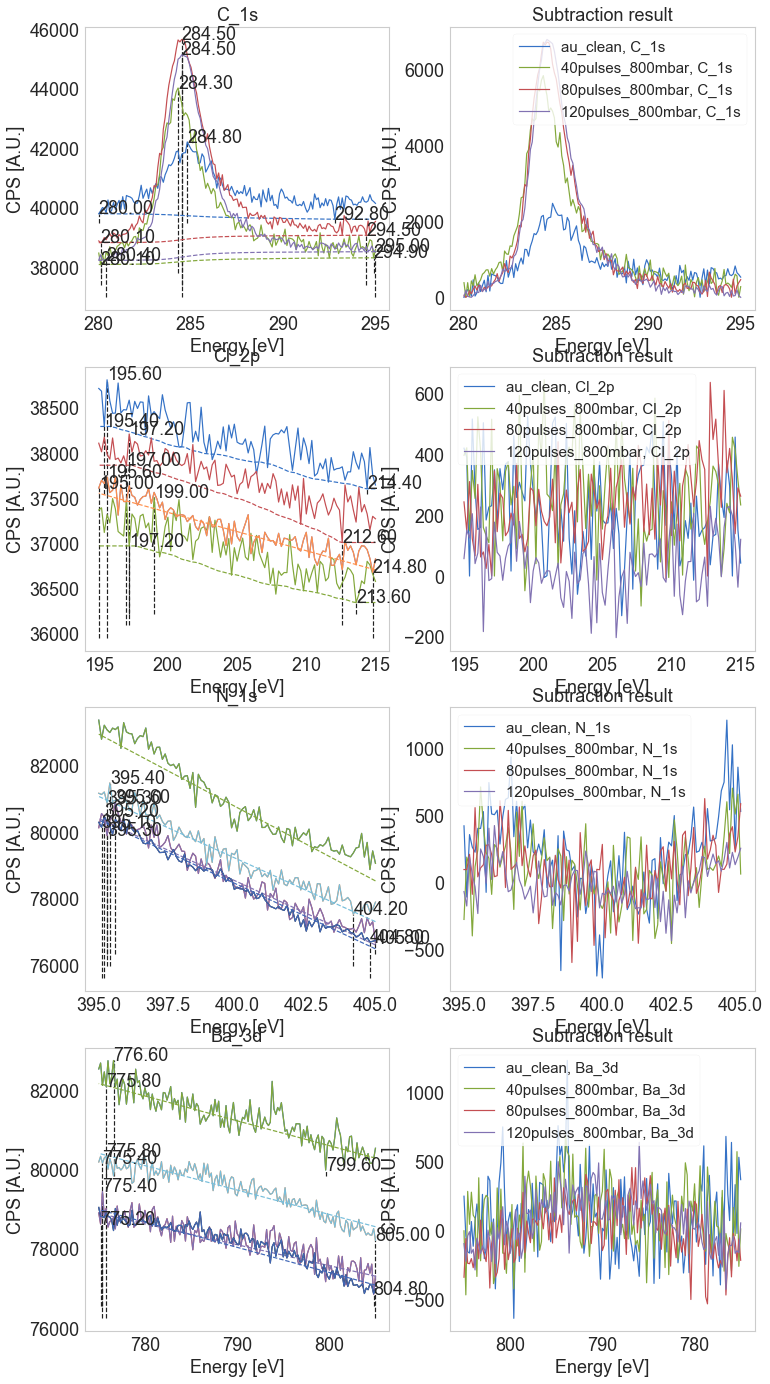

In [174]:
regions = ['C_1s', 'Cl_2p', 'N_1s', 'Ba_3d']
bg_exps = bulk_bg_subtract(bg_exps, regions)

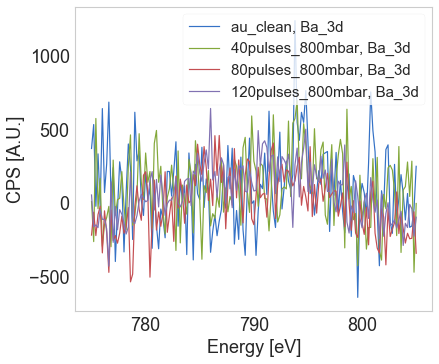

In [175]:
region = 'Ba_3d'
for xp in bg_exps:
    plot_region(xp, region)

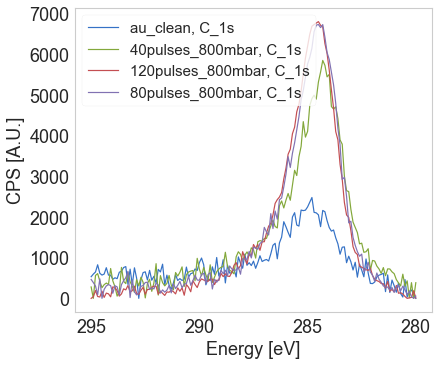

In [13]:
region = 'C_1s'
for xp in bg_exps:
    plot_region(xp, region)
cosmetics_plot()

### Review Ba bg subtraction

In [95]:
region = 'Ba_3d'

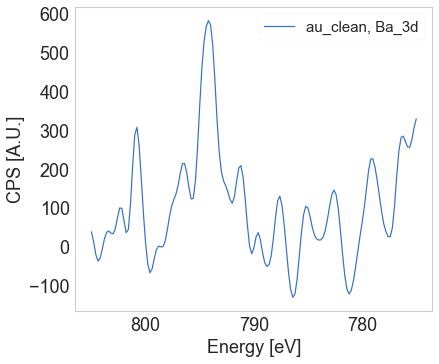

In [176]:
bg_exps[0] = gaussian_smooth(bg_exps[0], region, sigma=2)
plot_region(bg_exps[0], region)

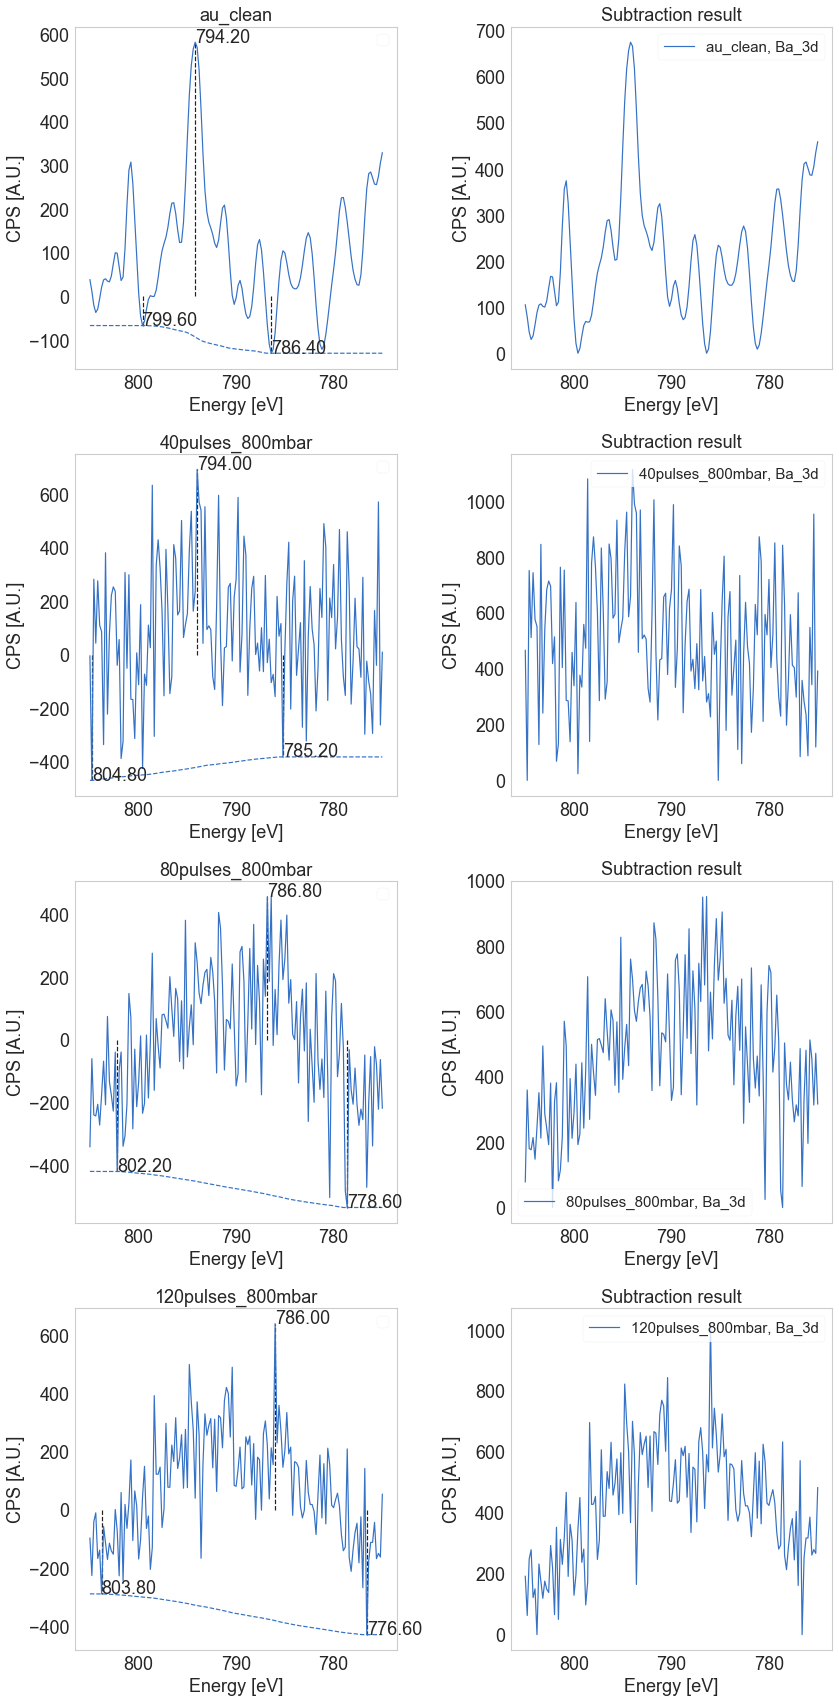

In [177]:
bg_exps = region_bg_subtract(bg_exps, 'Ba_3d')

### Subtract linear and shirley bg to all O 1s regions

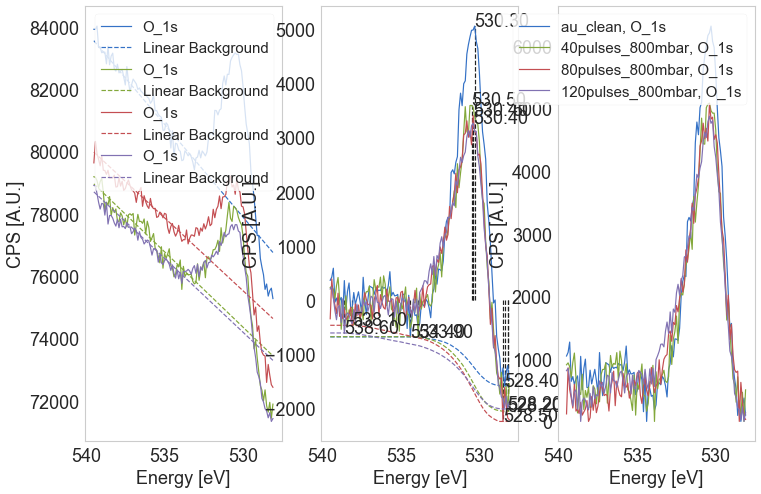

In [178]:
region = 'O_1s'
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
new_exps = []
for xp in bg_exps:
    xp_crop = crop_spectrum(xp, region, eup=539.5, edw=528)
    xp_lin = subtract_linear_bg(xp_crop, region, ax=ax[0])
    xp_bg = subtract_shirley_bg(xp_lin, region, maxit=40, ax=ax[1])
    plot_region(xp_bg, region, ax=ax[2])
    new_exps.append(xp_bg)
for i in range(3): cosmetics_plot(ax=ax[i])
bg_exps = new_exps

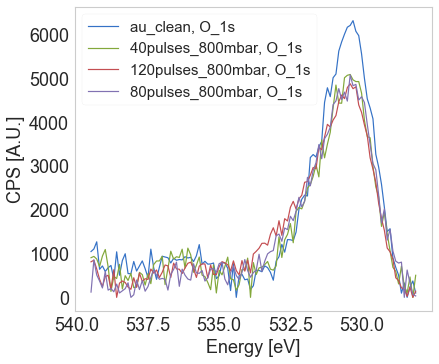

In [101]:
region = 'O_1s'
for xp in bg_exps:
    plot_region(xp, region)
cosmetics_plot()

## Scale to Au 4f

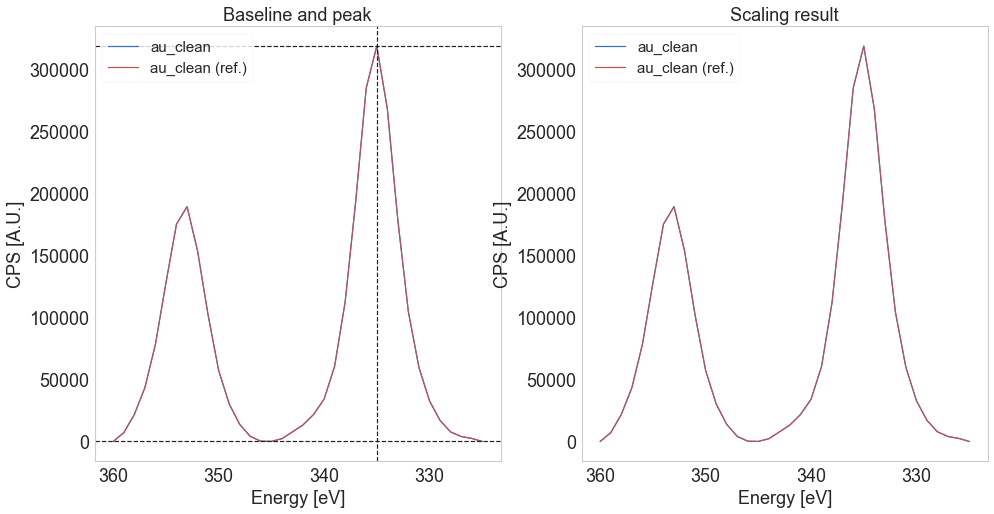

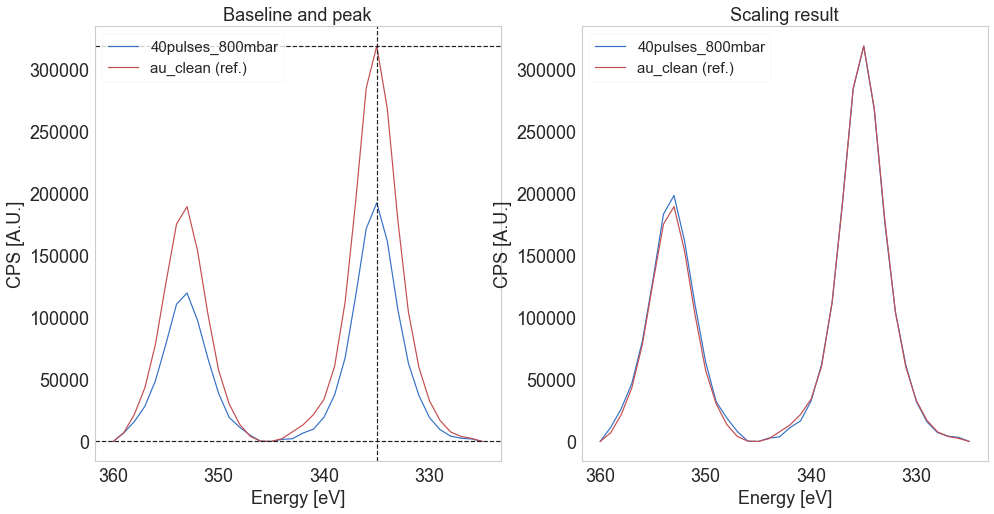

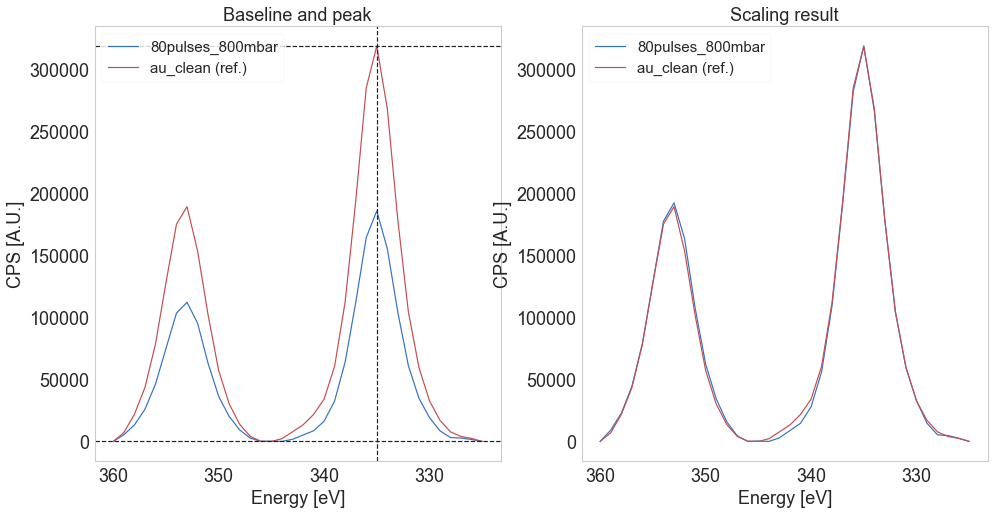

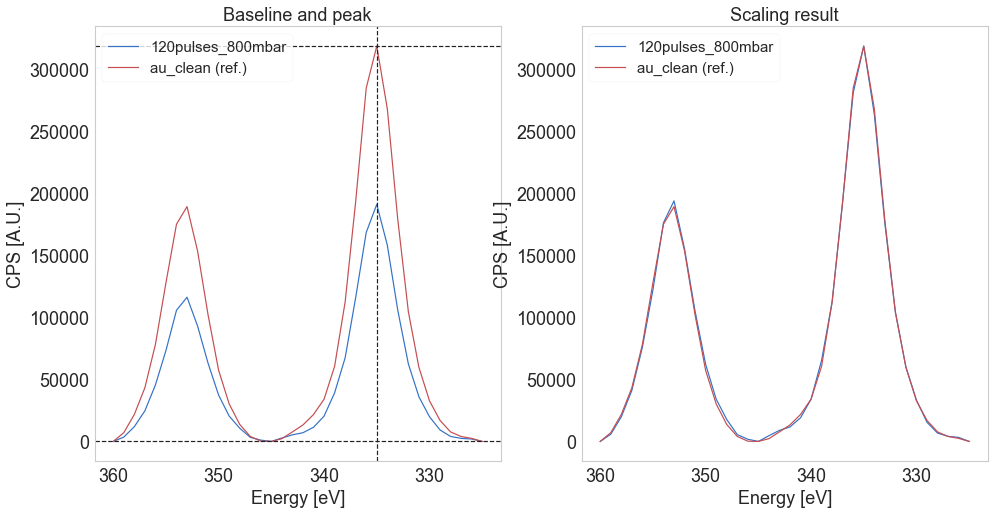

In [184]:
scaled_exps = []
for xpbg in bg_exps:
    scale = scale_and_plot_spectra(xp = xpbg, xpRef = bg_exps[0], region = 'overview_')
    scaled_exps.append(scale_dfx(xp = xpbg, scale_factor = scale))

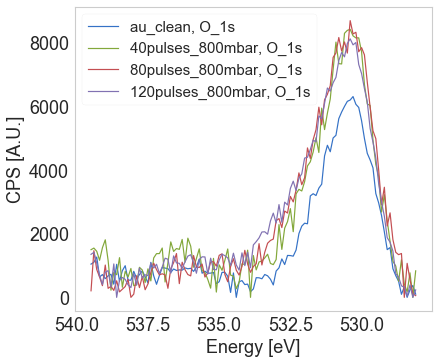

In [180]:
for xp in scaled_exps:
    plot_region(xp, 'O_1s')
cosmetics_plot()

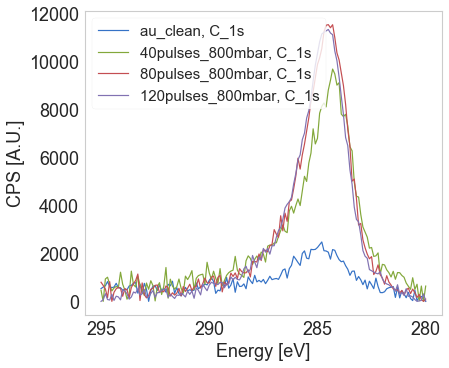

In [181]:
for xp in scaled_exps:
    plot_region(xp, 'C_1s')
cosmetics_plot()

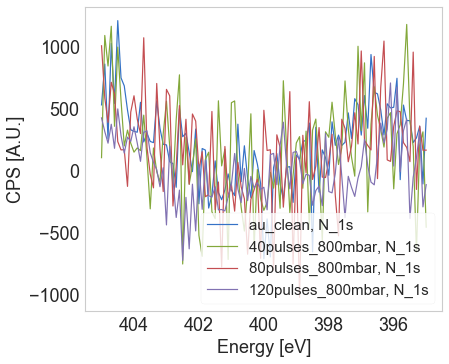

In [182]:
for xp in scaled_exps:
    plot_region(xp, 'N_1s')
cosmetics_plot()

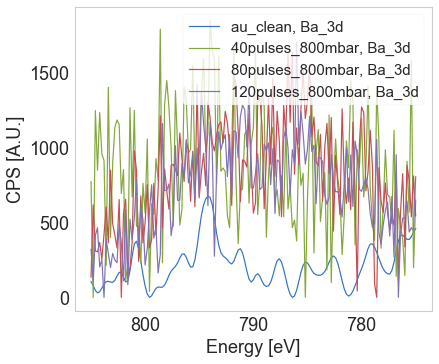

In [183]:
for xp in scaled_exps:
    plot_region(xp, 'Ba_3d')
cosmetics_plot()

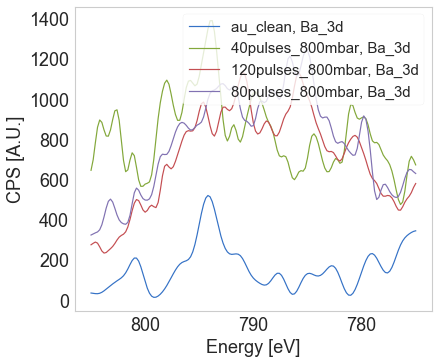

In [106]:
for xp in scaled_exps:
    plot_region(gaussian_smooth(xp, 'Ba_3d'), 'Ba_3d')
cosmetics_plot()

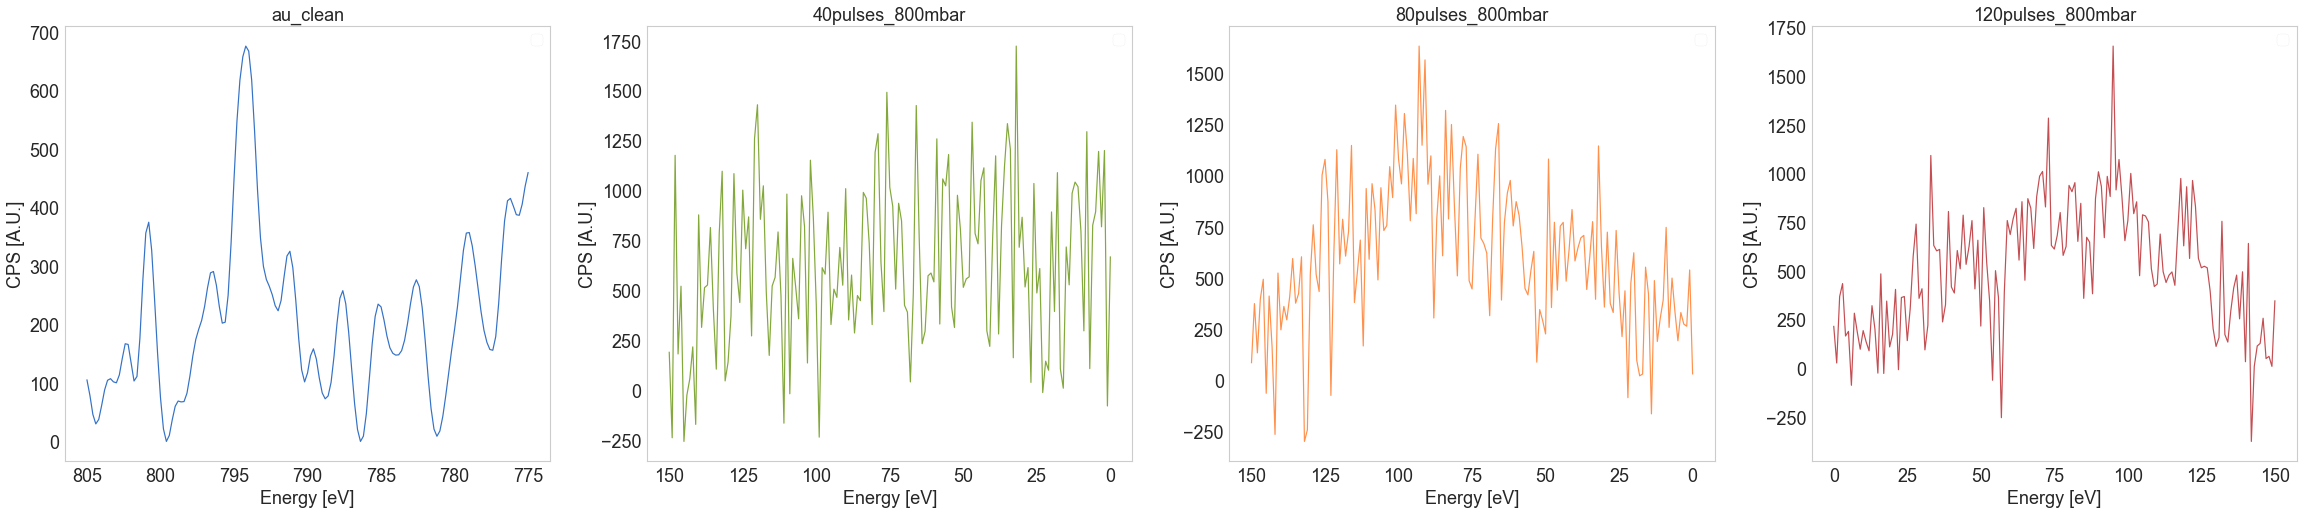

In [185]:
region = 'Ba_3d'
colors = ['b', 'g', 'y', 'r']
fig, ax = plt.subplots(1, 4, figsize=(40, 8))
for i,xp in enumerate(scaled_exps):
    if i == 0:   # Set labels from last region
        li = plot_region(xp, 'Ba_3d', ax=ax[i], lb='__nolabel__')
    else:
        dfsub = xp.dfx[region].counts-scaled_exps[0].dfx[region].counts
        li = ax[i].plot(dfsub, label='__nolabel__')[0]
    if len(colors) > 0: li.set_color(colors[i])
    ax[i].set_title(xp.name)
    cosmetics_plot(ax=ax[i])
# plt.tight_layout()

## Store processed experiments

In [186]:
import os
for xp, xpProc in zip(experiments, scaled_exps):
    filepath, filename = os.path.split(xp.path)
    newpath = filepath + '/proc/'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
#     print(newpath + filename)
    write_processed_xp(newpath + filename, xpProc)

# ALI injections 200 mbar
40, 80 and 120 pulses

At $t_{on}$ = 50 ms and C = 1µM

## Import data

In [136]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/**/*.xy'
files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if (' ' not in f) and ('/proc' not in f):
        files_new.append(f)
files = files_new[6:10]

for f in files:
    print(os.path.split(f)[1])

20191018_Au(788)_clean.xy
20191023_FBI_Ba_1uM_40pulse_50ms_Au(788)_350mbar.xy
20191023_FBI_Ba_1uM_80pulse_50ms_Au(788)_350mbars.xy
20191025_FBI_Ba_1uM_120pulse_50ms_Au(788)_350mbar.xy


In [137]:
names = ['au_clean', '40pulses_200mbar', '80pulses_200mbar', '120pulses_200mbar']
label = ['Au(788) clean', 'FBI-Ba 40pulses, 200mbar GAr', 'FBI-Ba 80pulses, 200mbar GAr', 'FBI-Ba 120pulses, 200mbar GAr']

experiments = [xps_data_import(path=f, name=n, label=l) for f,n,l in zip(files, names, label)]
experiments[1].name

'40pulses_200mbar'

## Bg subtraction

In [138]:
region = 'overview_'

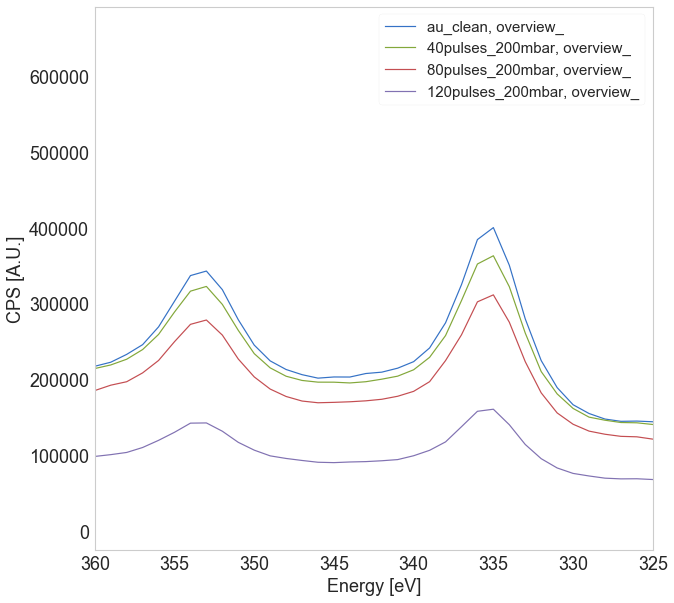

In [139]:
plt.figure(figsize=(10,10))
for xp in experiments:
    plot_region(xp, 'overview_')
plt.xlim(325, 360)
cosmetics_plot()

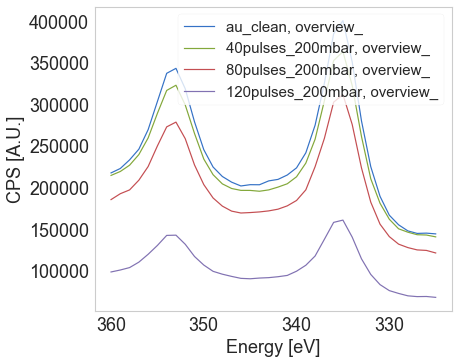

In [140]:
trim_exps = []
for xp in experiments:
    xp_new = crop_spectrum(xp, region=region, eup=360, edw=325)
    trim_exps.append(xp_new)
    plot_region(xp_new, region)
cosmetics_plot()

### Subtract double shirley to all Au regions

In [141]:
region = 'overview_'

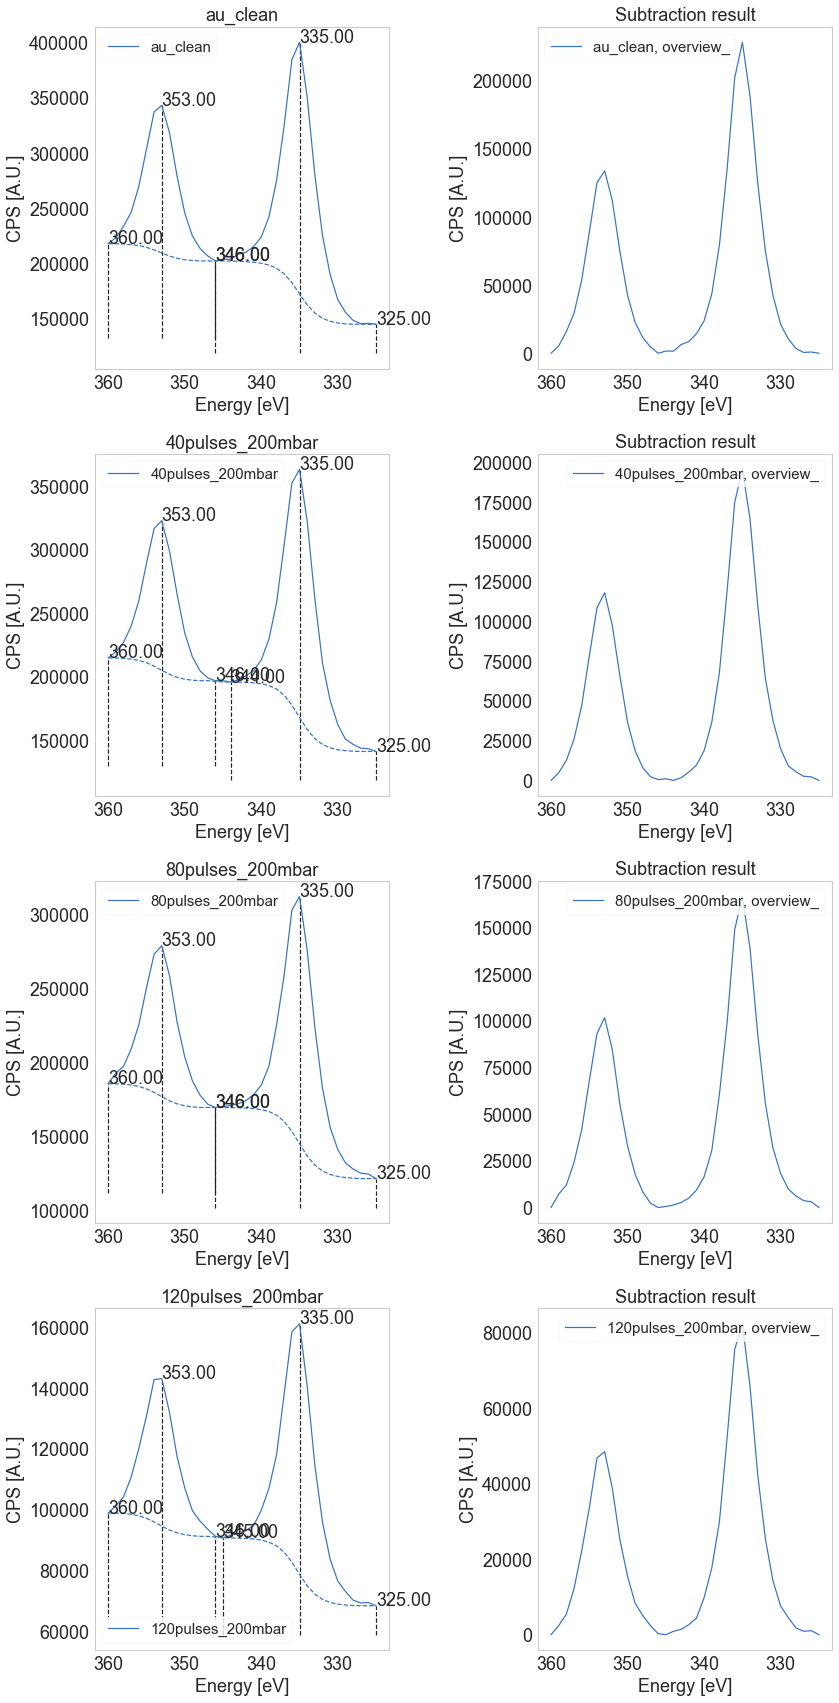

In [142]:
bg_exps = region_2bg_subtract(trim_exps, region=region, xlim=346)

### Bulk subtract background

Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline


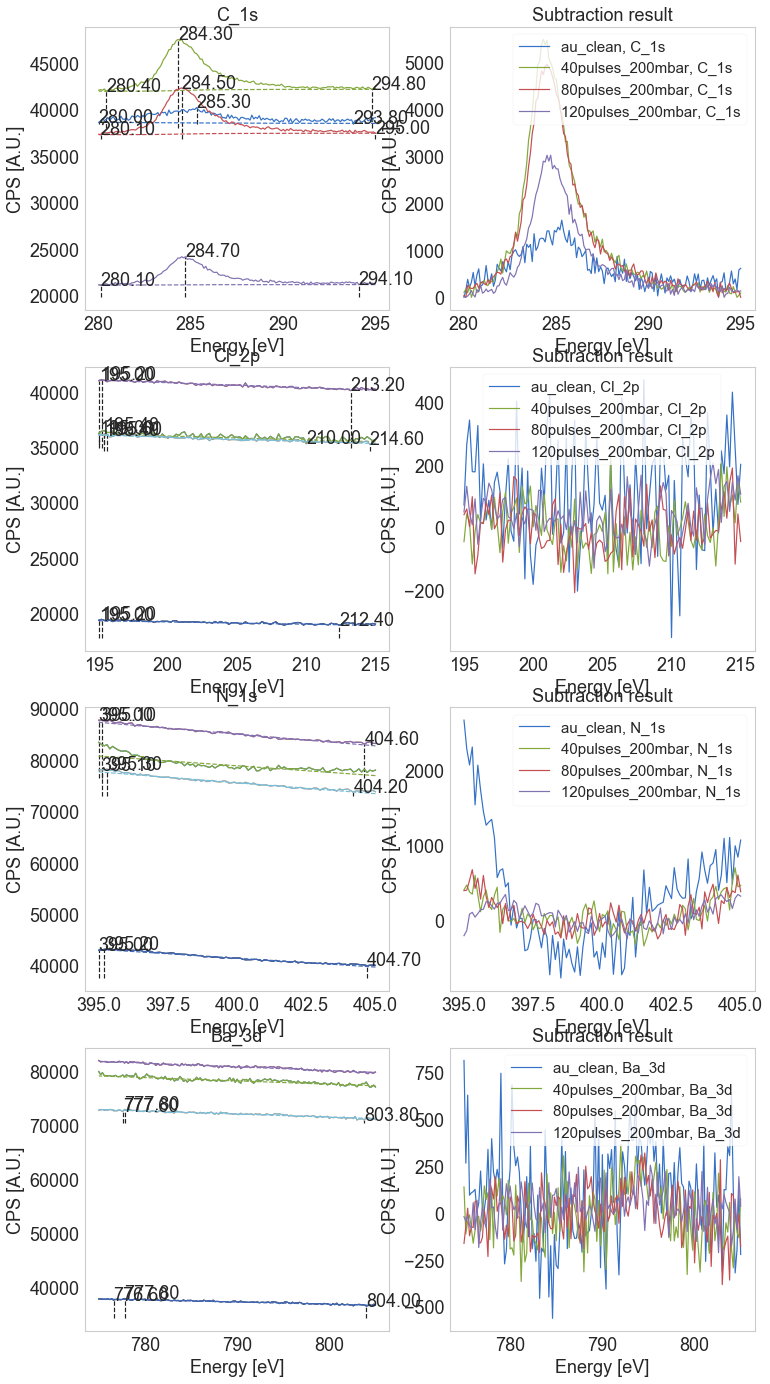

In [143]:
regions = ['C_1s', 'Cl_2p', 'N_1s', 'Ba_3d']
bg_exps = bulk_bg_subtract(bg_exps, regions)

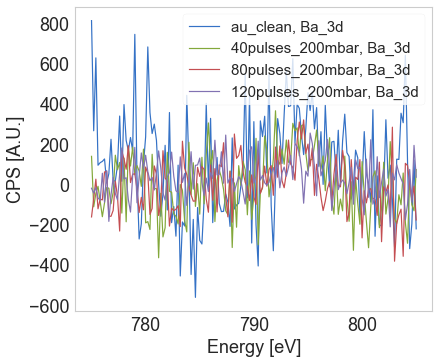

In [144]:
region = 'Ba_3d'
for xp in bg_exps:
    plot_region(xp, region)

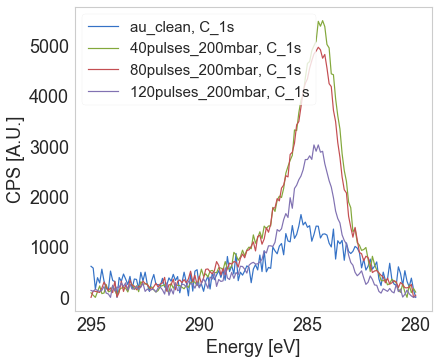

In [145]:
region = 'C_1s'
for xp in bg_exps:
    plot_region(xp, region)
cosmetics_plot()

### Review Ba 3d subtraction and smoothen

In [146]:
region = 'Ba_3d'

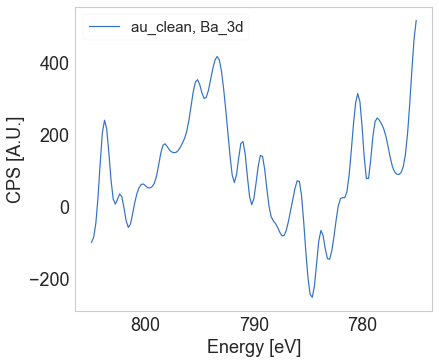

In [147]:
bg_ba = gaussian_smooth(bg_exps[0], region, sigma=2)
plot_region(bg_ba, region)

Max iterations exceeded, subtract linear baseline


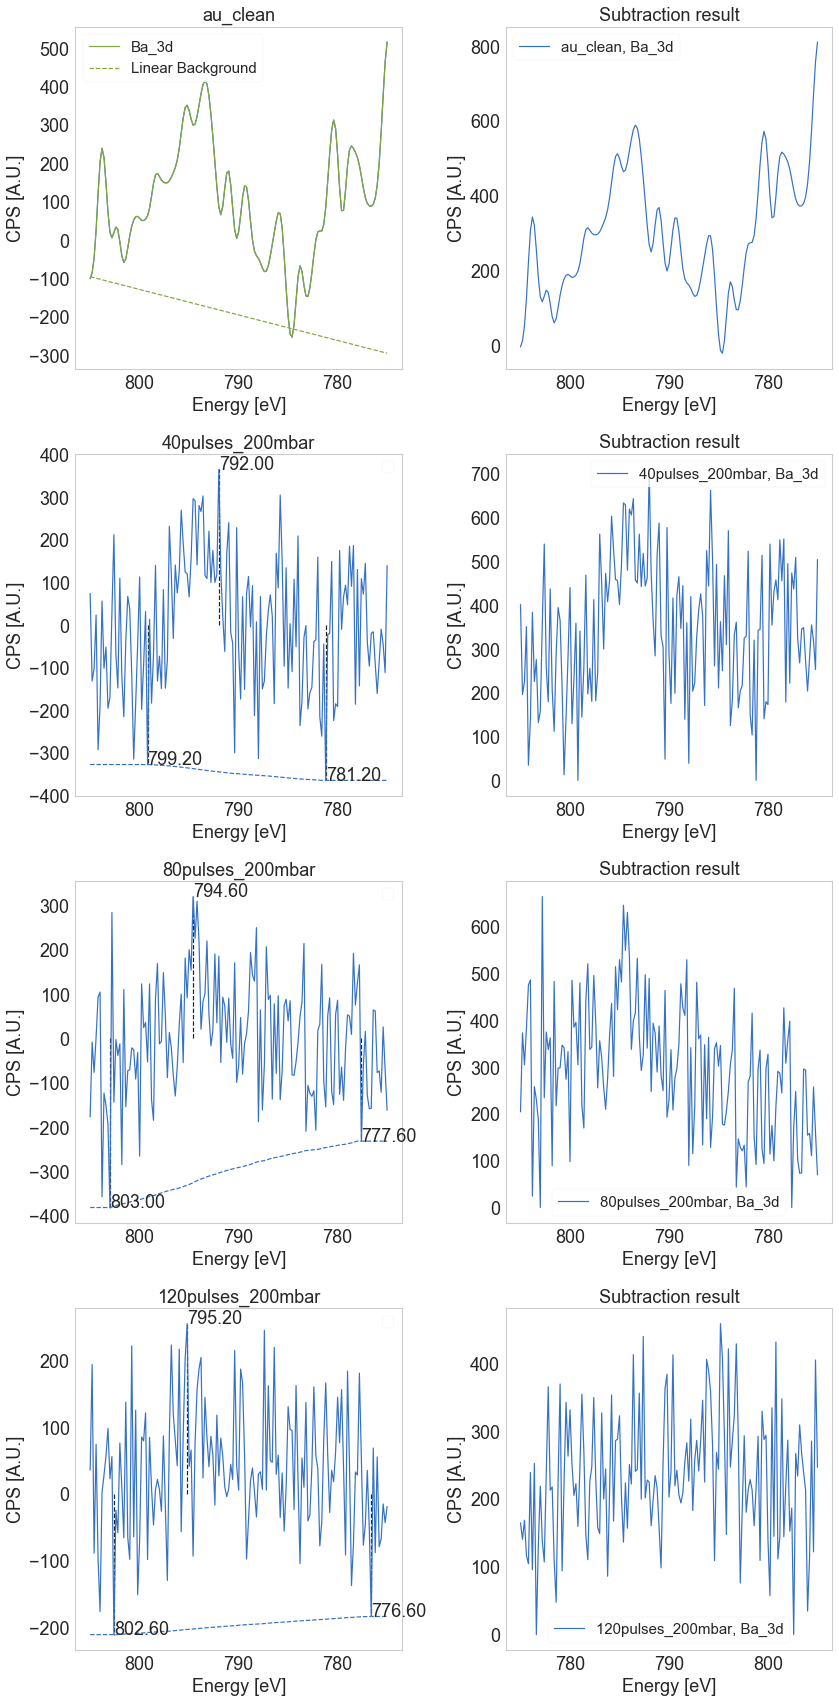

In [148]:
bg_exps = region_bg_subtract(bg_exps, 'Ba_3d')

### Subtract linear and shirley bg to all O 1s regions

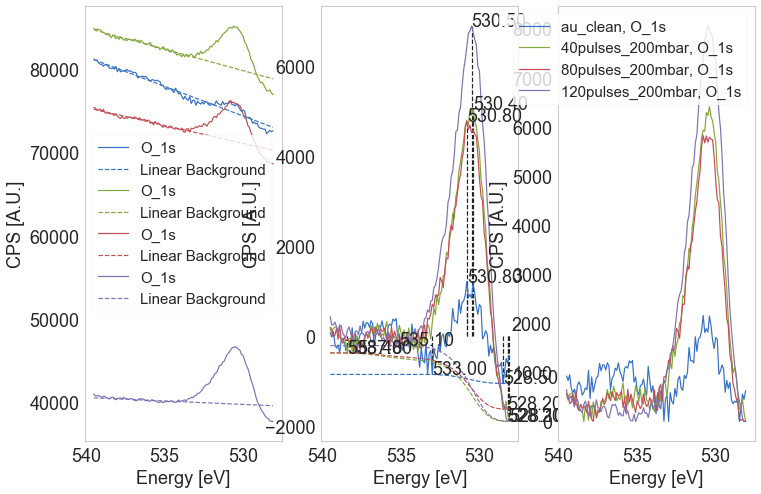

In [149]:
region = 'O_1s'
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
new_exps = []
for xp in bg_exps:
    xp_crop = crop_spectrum(xp, region, eup=539.5, edw=528)
    xp_lin = subtract_linear_bg(xp_crop, region, ax=ax[0])
    xp_bg = subtract_shirley_bg(xp_lin, region, maxit=40, ax=ax[1])
    plot_region(xp_bg, region, ax=ax[2])
    new_exps.append(xp_bg)
for i in range(3): cosmetics_plot(ax=ax[i])
bg_exps = new_exps

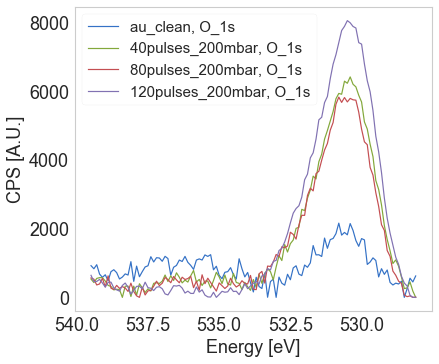

In [150]:
region = 'O_1s'
for xp in bg_exps:
    plot_region(xp, region)
cosmetics_plot()

## Scale to Au 4f

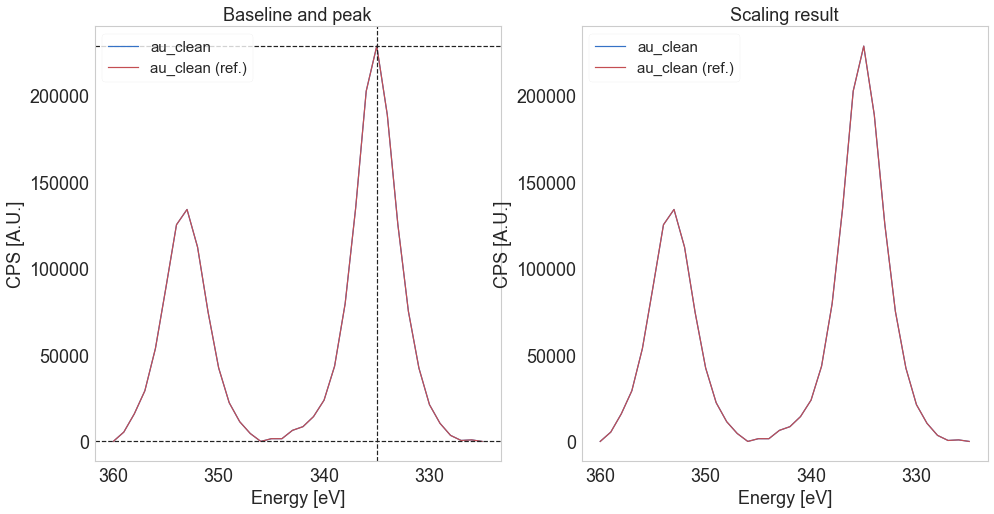

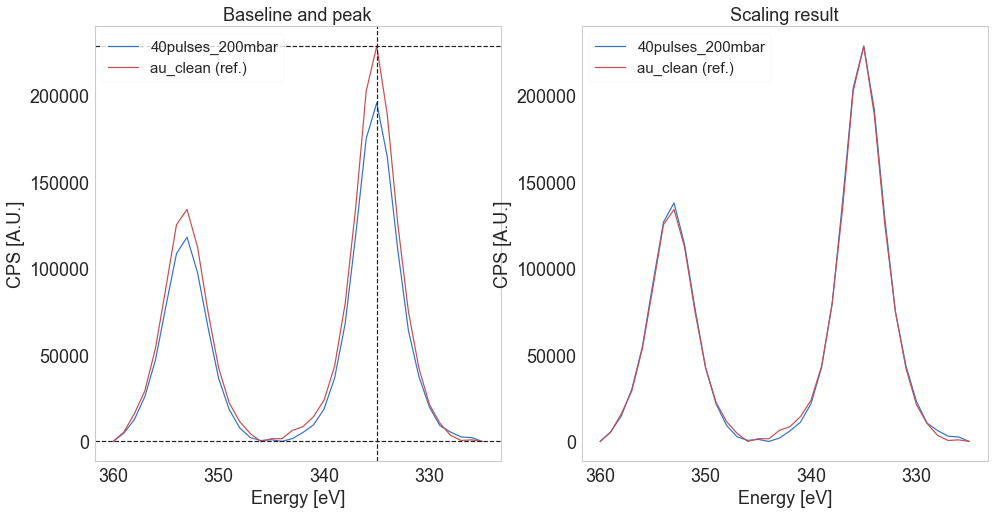

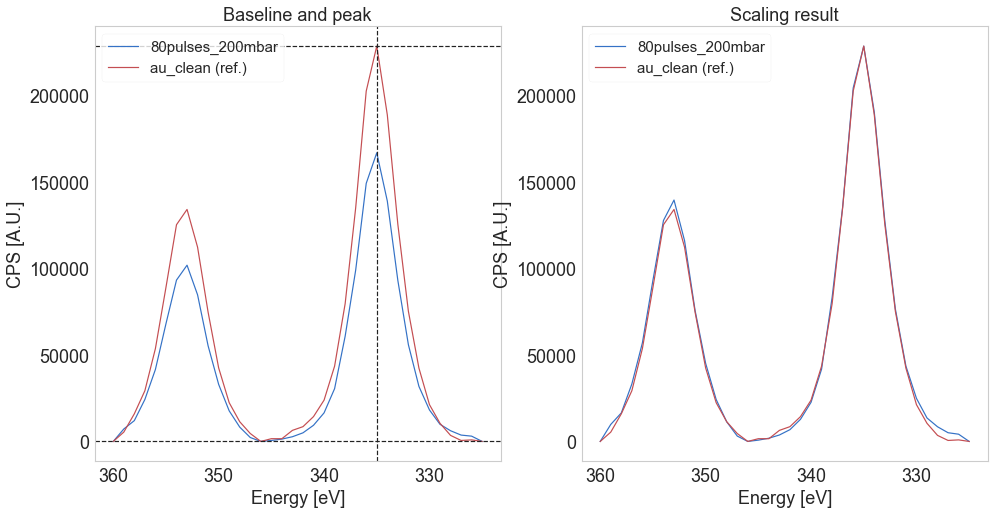

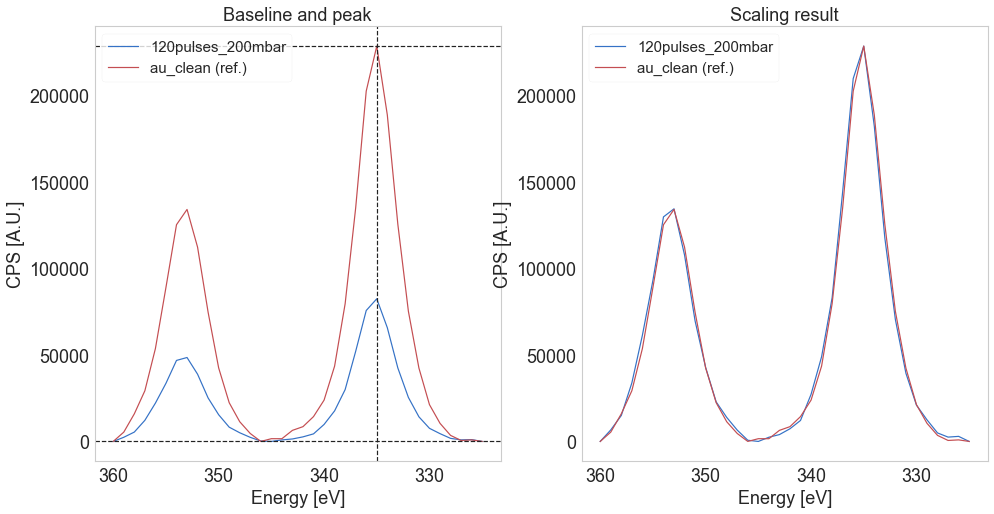

In [151]:
scaled_exps = []
for xpbg in bg_exps:
    scale = scale_and_plot_spectra(xp = xpbg, xpRef = bg_exps[0], region = 'overview_')
    scaled_exps.append(scale_dfx(xp = xpbg, scale_factor = scale))

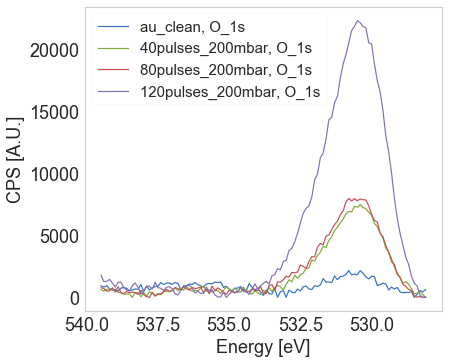

In [152]:
for xp in scaled_exps:
    plot_region(xp, 'O_1s')
cosmetics_plot()

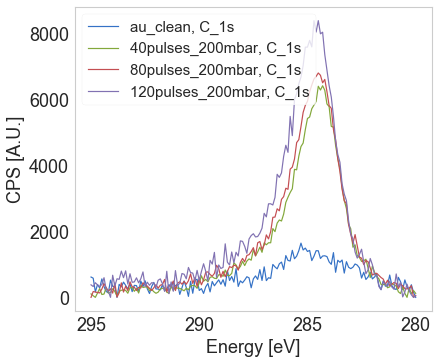

In [153]:
for xp in scaled_exps:
    plot_region(xp, 'C_1s')
cosmetics_plot()

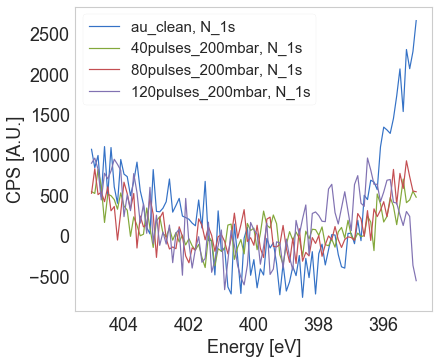

In [154]:
for xp in scaled_exps:
    plot_region(xp, 'N_1s')
cosmetics_plot()

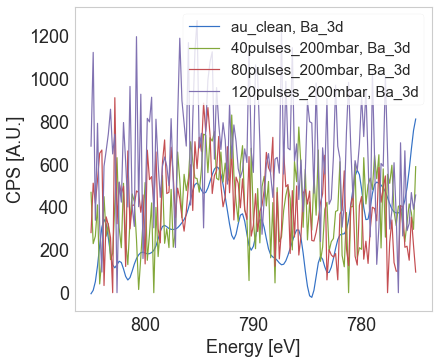

In [155]:
for xp in scaled_exps:
    plot_region(xp, 'Ba_3d')
cosmetics_plot()

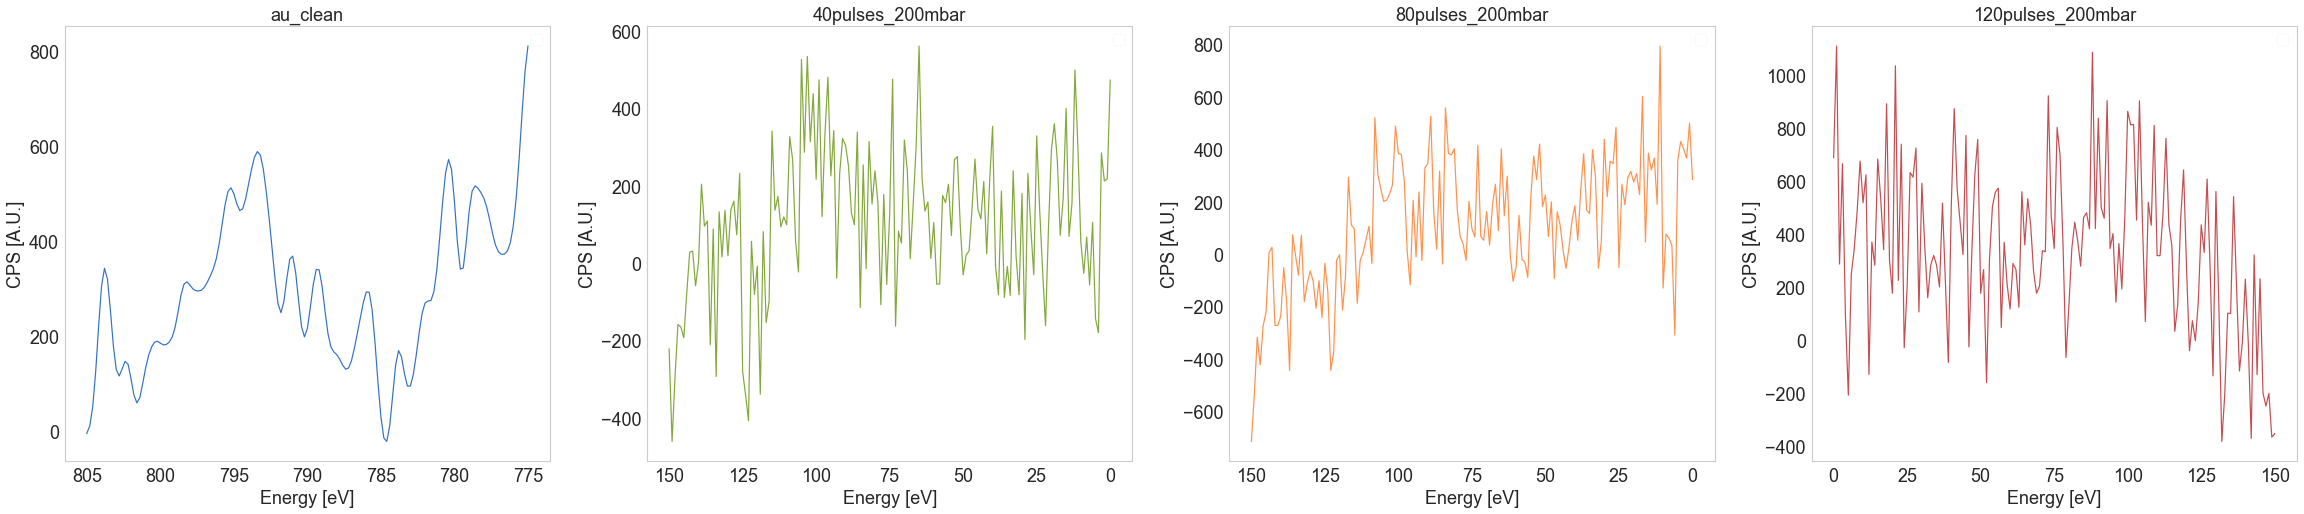

In [156]:
region = 'Ba_3d'
colors = ['b', 'g', 'y', 'r']
fig, ax = plt.subplots(1, 4, figsize=(40, 8))
for i,xp in enumerate(scaled_exps):
    if i == 0:   # Set labels from last region
        li = plot_region(xp, 'Ba_3d', ax=ax[i], lb='__nolabel__')
    else:
        dfsub = xp.dfx[region].counts-scaled_exps[0].dfx[region].counts
        li = ax[i].plot(dfsub, label='__nolabel__')[0]
    if len(colors) > 0: li.set_color(colors[i])
    ax[i].set_title(xp.name)
    cosmetics_plot(ax=ax[i])
# plt.tight_layout()

## Store processed experiments

In [157]:
import os
for xp, xpProc in zip(experiments, scaled_exps):
    filepath, filename = os.path.split(xp.path)
    newpath = filepath + '/proc/'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
#     print(newpath + filename)
    write_processed_xp(newpath + filename, xpProc)

# FBI dropcast data

## Import raw spectra

In [83]:
path = '/Users/pabloherrero/sabat/xps_spectra/Au788_FBI/**/*.xy'
files = glob.glob(path, recursive=True)
files.sort()
files_new = []
for f in files:
    if (' ' not in f) and ('/proc' not in f):
        files_new.append(f)
files = files_new[10:]

for f in files:
    print(os.path.split(f)[1])

20191028_Au(788)_clean.xy
20191028_FBI_dropcast_1mM_Au(788).xy
20191029_Au(788)_sputter_1500ev.xy
20191030_FBI_Ba_Au(788)_sputter_2kev.xy
20191031_FBI_Ba_Au(788)_2ndSputter_2kev.xy


In [111]:
names = ['au_clean', 'FBI_dropcast_1mM', 'FBI_sputter1500', 'FBI_sputter2000a', 'FBI_sputter2000b']
label = ['Au(788) clean', 'FBI-Ba 2 droplet dropcast 1mM', 'FBI-Ba 1st sputter 1.5 keV', 'FBI-Ba 2nd sputter 2 keV', 'FBI-Ba 3rd sputter 2 keV']

experiments = [xps_data_import(path=f, name=n, label=l) for f,n,l in zip(files, names, label)]
experiments[1].name

'FBI_dropcast_1mM'

In [112]:
experiments[1].dfx

range           overview            C_1s           Ba_3d            N_1s  \
properties        energy   counts energy   counts energy   counts energy   
0           1.200000e+03  81187.5  295.0  13383.5  805.0  29344.5  405.0   
1           1.199000e+03  81632.5  294.9  13380.5  804.8  29333.0  404.9   
2           1.198000e+03  81797.5  294.8  13208.0  804.6  29242.5  404.8   
3           1.197000e+03  81067.5  294.7  13359.5  804.4  29116.5  404.7   
4           1.196000e+03  81270.0  294.6  13202.0  804.2  29168.0  404.6   
5           1.195000e+03  82432.5  294.5  13120.0  804.0  29240.0  404.5   
6           1.194000e+03  81317.5  294.4  13150.0  803.8  29156.0  404.4   
7           1.193000e+03  81287.5  294.3  13003.0  803.6  29149.0  404.3   
8           1.192000e+03  80570.0  294.2  13120.5  803.4  29061.5  404.2   
9           1.191000e+03  79990.0  294.1  13133.5  803.2  29016.0  404.1   
10          1.190000e+03  79622.5  294.0  13276.5  803.0  29245.5  404.0   
11          1.189000e+03  79497.5  293.9  13209.0  802.8  29221.0  403.9   
12          1.188000e+03  78980.0  293.8  13033.0  802.6  29060.5  403.8   
13          1.187000e+03  78422.5  293.7  13024.0  802.4  29086.5  403.7   
14          1.186000e+03  78667.5  293.6  13047.5  802.2  29107.0  403.6   
15          1.185000e+03  78132.5  293.5  12942.5  802.0  29163.5  403.5   
16          1.184000e+03  78847.5  293.4  12989.5  801.8  29216.5  403.4   
17          1.183000e+03  78435.0  293.3  12990.5  801.6  28907.5  403.3   
18          1.182000e+03  77805.0  293.2  12882.5  801.4  29170.5  403.2   
19          1.181000e+03  76970.0  293.1  12890.5  801.2  28998.0  403.1   
20          1.180000e+03  77085.0  293.0  13160.0  801.0  28927.0  403.0   
21          1.179000e+03  78097.5  292.9  12906.5  800.8  29217.5  402.9   
22          1.178000e+03  77492.5  292.8  13121.5  800.6  29285.0  402.8   
23          1.177000e+03  77397.5  292.7  12953.0  800.4  29202.0  402.7   
24          1.176000e+03  76802.5  292.6  13012.5  800.2  29347.0  402.6   
25          1.175000e+03  76870.0  292.5  12935.0  800.0  29351.5  402.5   
26          1.174000e+03  76242.5  292.4  12968.5  799.8  29441.5  402.4   
27          1.173000e+03  76357.5  292.3  13075.0  799.6  29783.5  402.3   
28          1.172000e+03  75612.5  292.2  12944.5  799.4  29912.0  402.2   
29          1.171000e+03  76242.5  292.1  12986.0  799.2  30026.5  402.1   
...                  ...      ...    ...      ...    ...      ...    ...   
1175        2.500000e+01   7620.0    NaN      NaN    NaN      NaN    NaN   
1176        2.400000e+01   7402.5    NaN      NaN    NaN      NaN    NaN   
1177        2.300000e+01   7290.0    NaN      NaN    NaN      NaN    NaN   
1178        2.200000e+01   7322.5    NaN      NaN    NaN      NaN    NaN   
1179        2.100000e+01   6847.5    NaN      NaN    NaN      NaN    NaN   
1180        2.000000e+01   6152.5    NaN      NaN    NaN      NaN    NaN   
1181        1.900000e+01   6162.5    NaN      NaN    NaN      NaN    NaN   
1182        1.800000e+01   5897.5    NaN      NaN    NaN      NaN    NaN   
1183        1.700000e+01   6142.5    NaN      NaN    NaN      NaN    NaN   
1184        1.600000e+01   5925.0    NaN      NaN    NaN      NaN    NaN   
1185        1.500000e+01   5522.5    NaN      NaN    NaN      NaN    NaN   
1186        1.400000e+01   5367.5    NaN      NaN    NaN      NaN    NaN   
1187        1.300000e+01   5170.0    NaN      NaN    NaN      NaN    NaN   
1188        1.200000e+01   5047.5    NaN      NaN    NaN      NaN    NaN   
1189        1.100000e+01   4812.5    NaN      NaN    NaN      NaN    NaN   
1190        1.000000e+01   4667.5    NaN      NaN    NaN      NaN    NaN   
1191        9.000000e+00   5052.5    NaN      NaN    NaN      NaN    NaN   
1192        8.000000e+00   5155.0    NaN      NaN    NaN      NaN    NaN   
1193        7.000000e+00   5725.0    NaN      NaN    NaN      NaN    NaN   
1194        6.000000e+00   5932.5    NaN      Na

## Bg subtraction

In [168]:
region = 'overview'

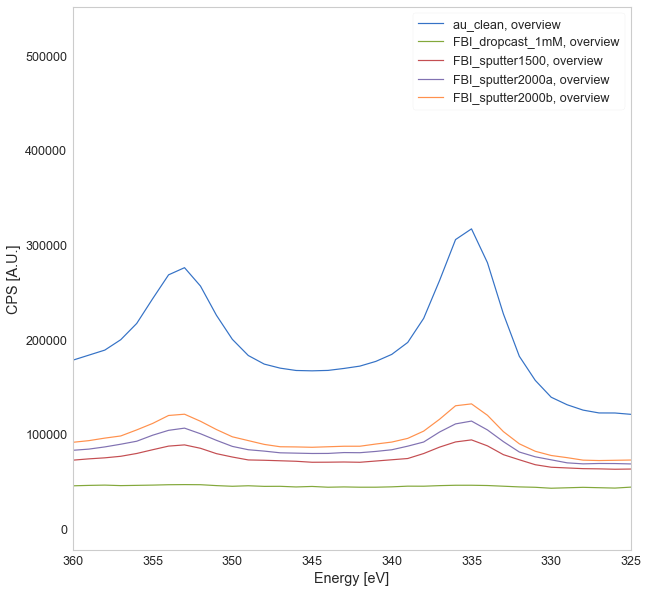

In [88]:
plt.figure(figsize=(10,10))
for xp in experiments:
    plot_region(xp, 'overview')
plt.xlim(325, 360)
cosmetics_plot()

### Trim overview to Au 4f region

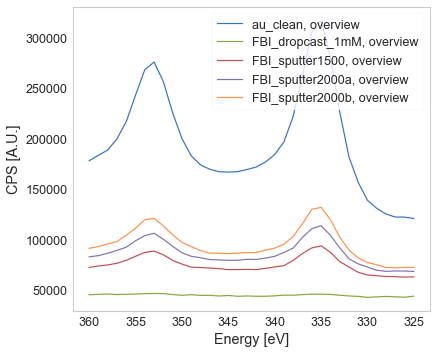

In [169]:
trim_exps = []
for xp in experiments:
    xp_new = crop_spectrum(xp, region=region, eup=360, edw=325)
    trim_exps.append(xp_new)
    plot_region(xp_new, region)
cosmetics_plot()
plt.gca().invert_xaxis()

### Compare two different overviews

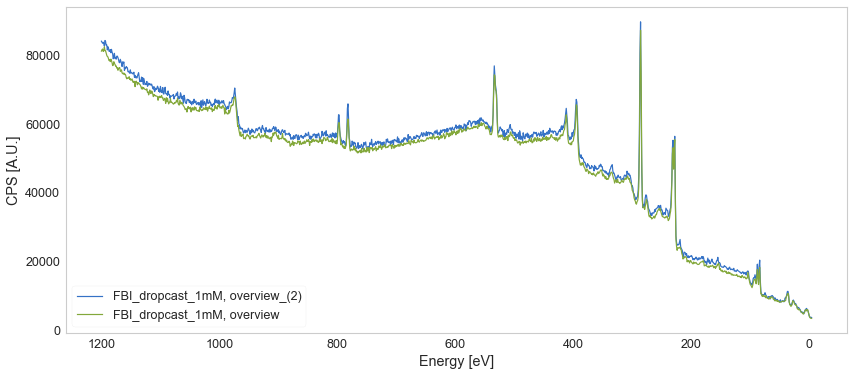

In [69]:
plt.figure(figsize=(14,6))
plot_region(experiments[1], 'overview_(2)')
plot_region(experiments[1], 'overview')
# plt.xlim(325, 360)
# plt.ylim(4e4, 5e4)
cosmetics_plot()

### Subtract double shirley to all Au regions

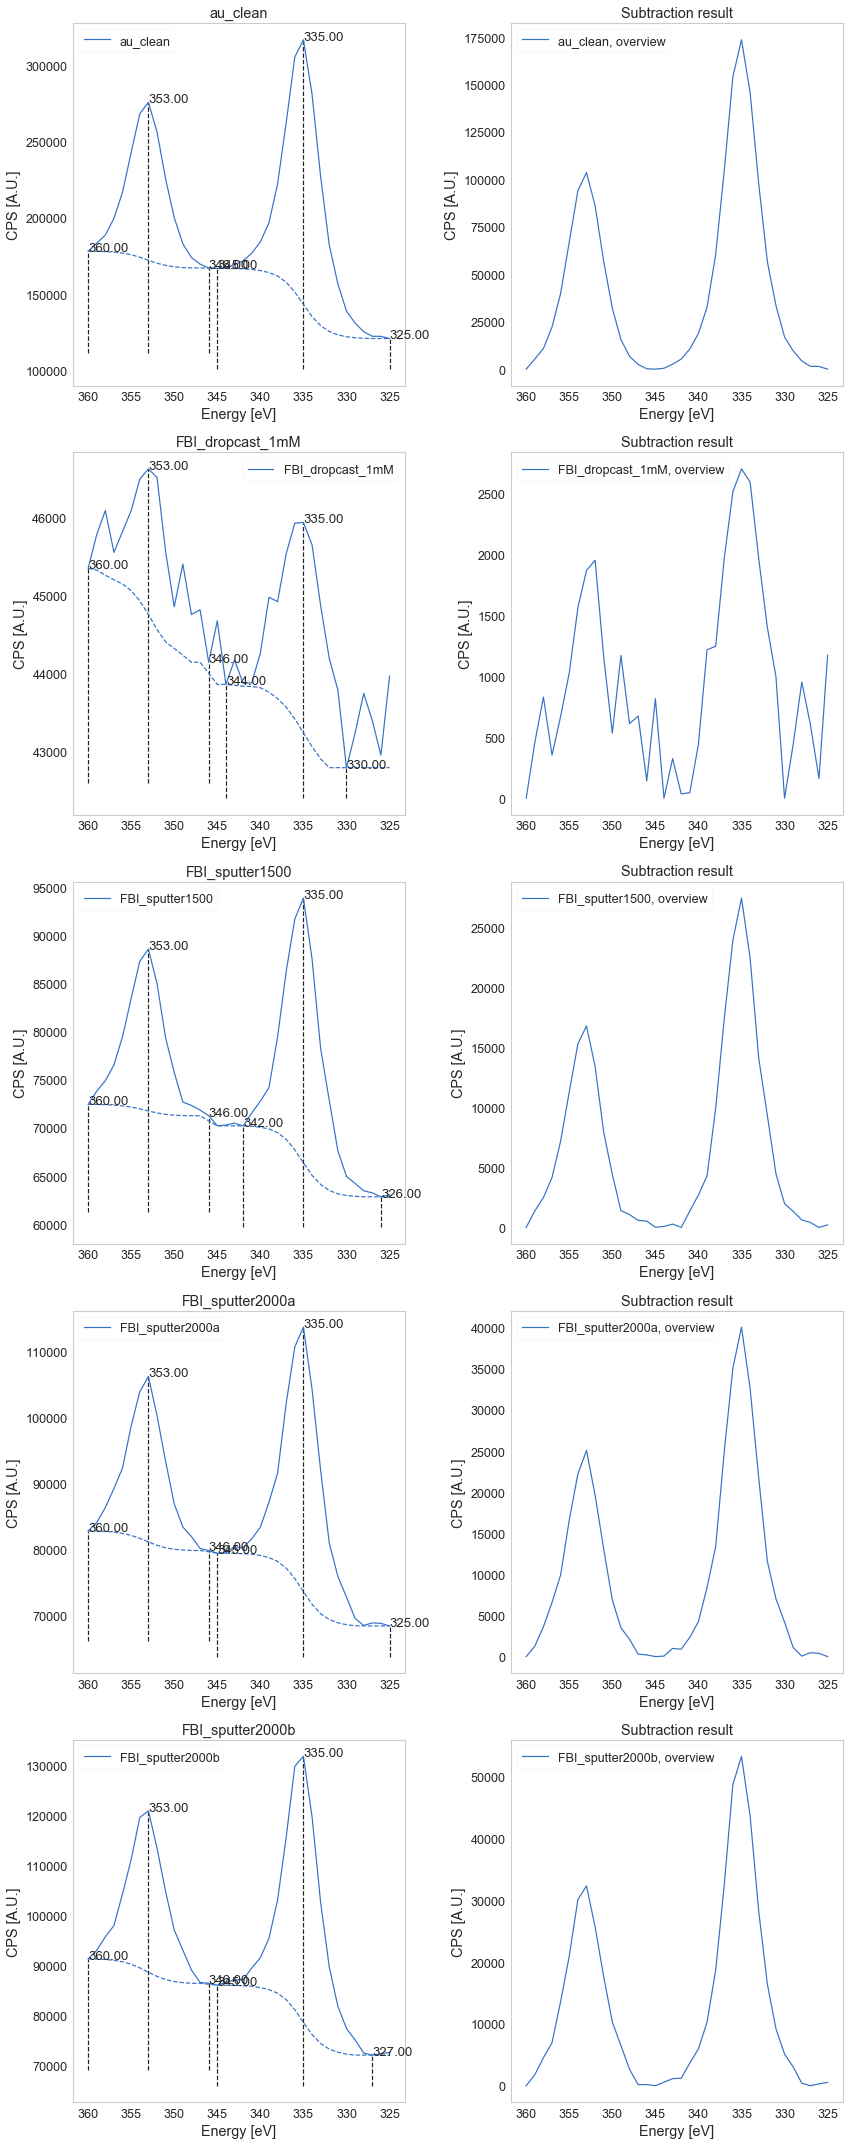

In [192]:
region = 'overview'

bg_exps = region_2bg_subtract(trim_exps, region=region, xlim = 346)

### Bulk subtract background

Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline
Max iterations exceeded, subtract linear baseline


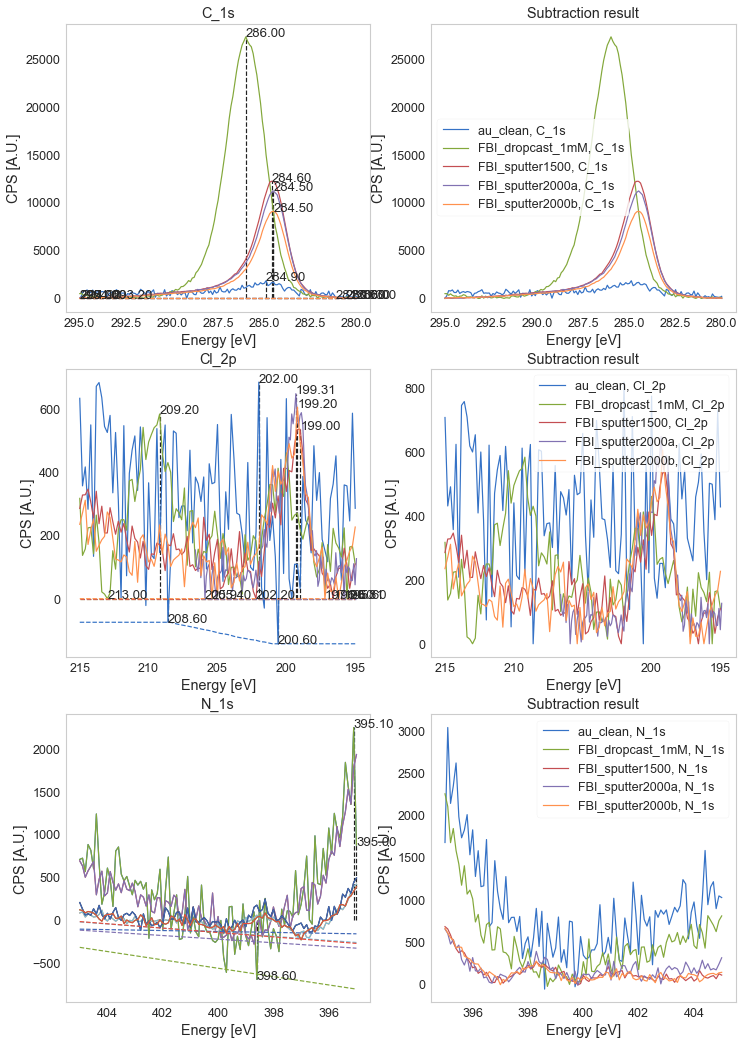

In [221]:
regions = ['C_1s', 'Cl_2p', 'N_1s']
bg_exps = bulk_bg_subtract(bg_exps, regions)

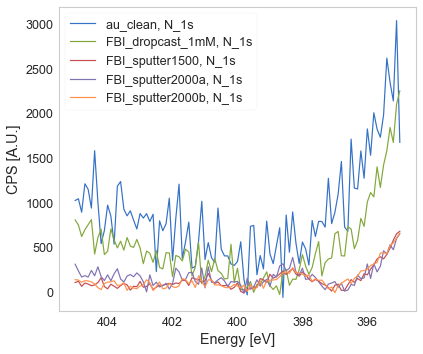

In [222]:
region = 'N_1s'
for xp in bg_exps:
    plot_region(xp, region)

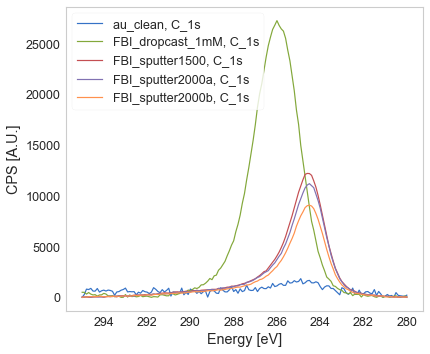

In [195]:
region = 'C_1s'
for xp in bg_exps:
    plot_region(xp, region)

### Review Ba 3d bg with double shirley

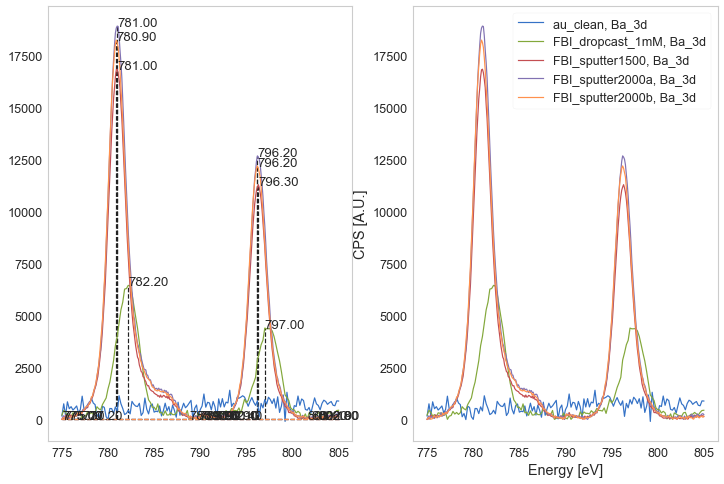

In [228]:
region = 'Ba_3d'

fig, ax = plt.subplots(1, 2, figsize=(12, 8))
new_exps = []
for i,xp in enumerate(bg_exps):
    if i == 0:
        xp_bg = subtract_linear_bg(xp, region, ax=ax[0])
    else:
        xp_bg = subtract_double_shirley(xp, region, xlim=790, maxit=40, flag_plot=True, ax=ax[0])
    plot_region(xp_bg, region, ax=ax[1])
    new_exps.append(xp_bg)
# for i in range(3): cosmetics_plot(ax=ax[i])
bg_exps = new_exps

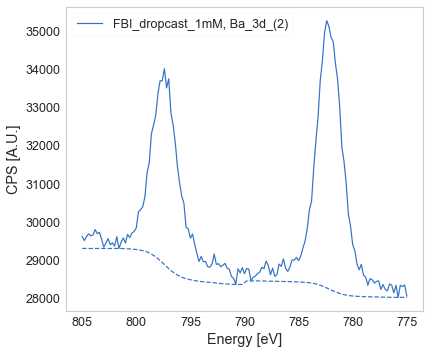

In [59]:
region = 'Ba_3d_(2)'
bg_exps2 = subtract_double_shirley(trim_exps[1], region, xlim=790)

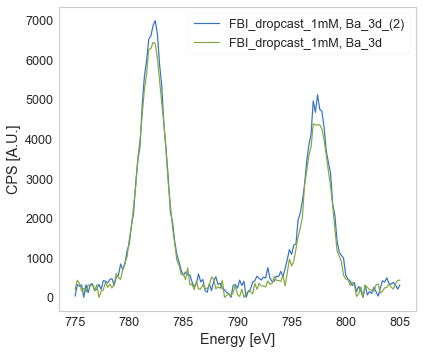

In [63]:
plot_region(bg_exps2, 'Ba_3d_(2)')
plot_region(bg_exps[1], 'Ba_3d')

### Subtract linear and shirley bg to all O 1s regions

/Users/pabloherrero/sabat/sabatsw/xps/xps_analysis.py:51: RuntimeWarning: invalid value encountered in greater
  dropup = np.where(xp.dfx[region].energy.values > eup)[0]


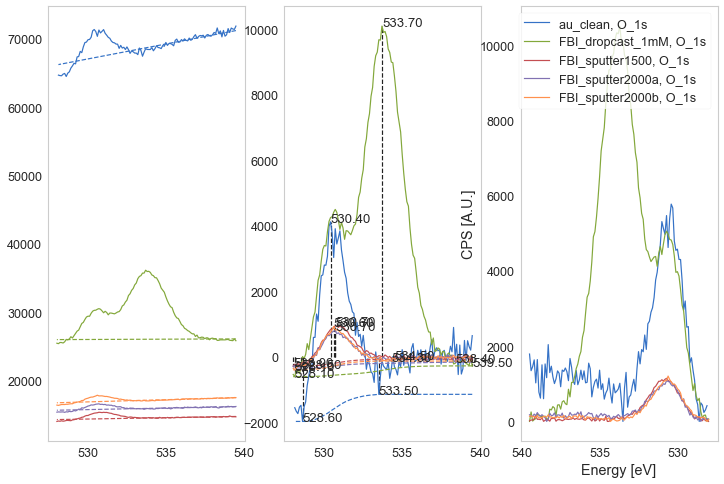

In [199]:
region = 'O_1s'
fig, ax = plt.subplots(1, 3, figsize=(12, 8))
new_exps = []
for xp in bg_exps:
    xp_crop = crop_spectrum(xp, region, eup=539.5, edw=528)
    xp_lin = subtract_linear_bg(xp_crop, region, ax=ax[0])
    xp_bg = subtract_shirley_bg(xp_lin, region, maxit=40, ax=ax[1])
    plot_region(xp_bg, region, ax=ax[2])
    new_exps.append(xp_bg)
# for i in range(3): cosmetics_plot(ax=ax[i])
bg_exps = new_exps

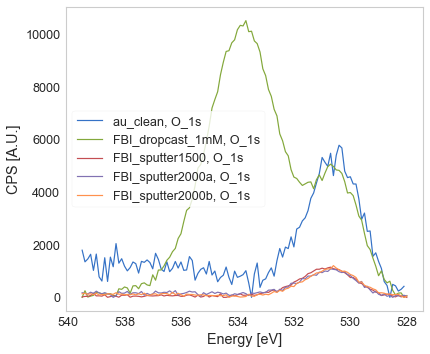

In [229]:
region = 'O_1s'
for xp in bg_exps:
    plot_region(xp, region)
cosmetics_plot()
plt.gca().invert_xaxis()

### Cl 2s

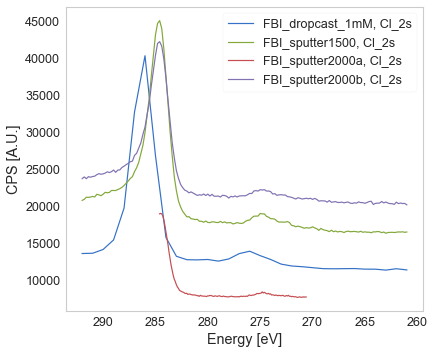

In [190]:
region = 'Cl_2s'
for xp in bg_exps[1:]:
    plot_region(xp, region)
# plt.xlim(280, 260)
# plt.ylim(5.5e3, 25e3)
# plt.yscale('log')
plt.gca().invert_xaxis()

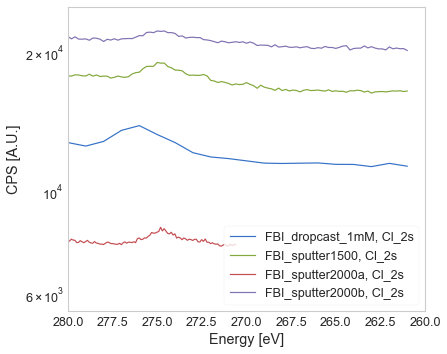

In [100]:
region = 'Cl_2s'
for xp in bg_exps[1:]:
    plot_region(xp, region)
plt.xlim(280, 260)
plt.ylim(5.5e3, 25e3)
plt.yscale('log')
# plt.gca().invert_xaxis()

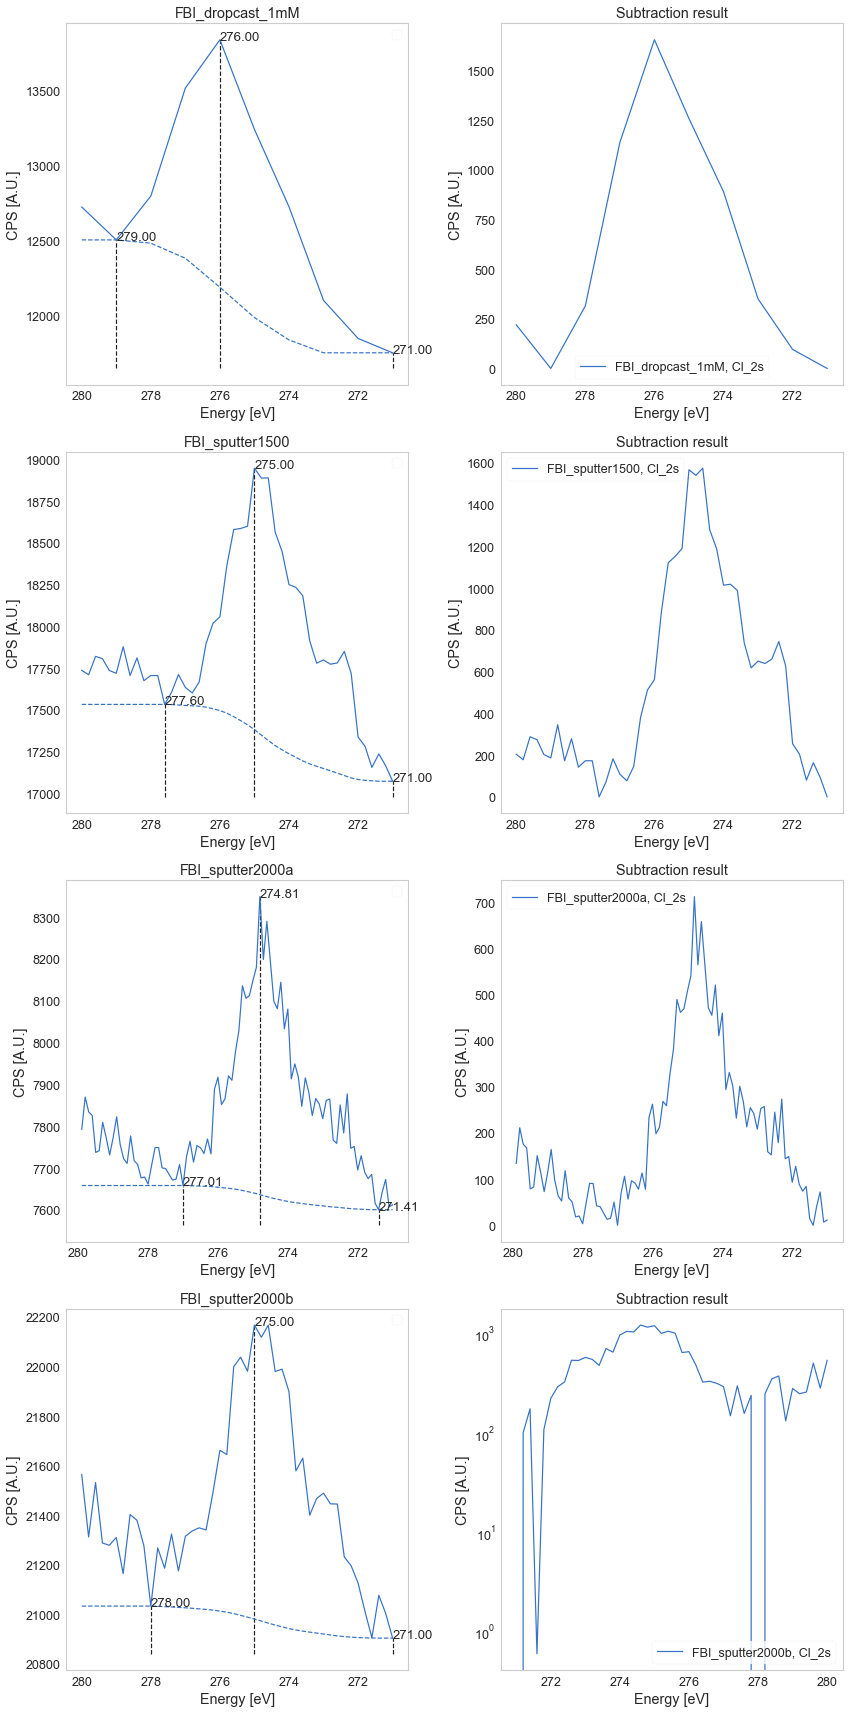

In [202]:
region = 'Cl_2s'

fig, ax = plt.subplots(len(bg_exps[1:]), 2, figsize=(12, 6 * len(bg_exps[1:])))
for j, xp in enumerate(bg_exps[1:]):
    xp_crop = crop_spectrum(xp, region, eup=280, edw=271)
    
    try:
        xp_bg = subtract_shirley_bg(xp_crop, region, maxit=100, lb='__nolabel__', ax = ax[j][0])
    except AssertionError:
        print('Max iterations exceeded, subtract linear baseline')
        xp_bg = subtract_linear_bg(xp_crop, region, lb='__nolabel__', ax = ax[j][0])

    xp.dfx[region] = xp_bg.dfx[region]
    plot_region(xp_bg, region, ax=ax[j][1])
    ax[j][0].set_title(xp.name)
    ax[j][1].set_title('Subtraction result')
    for i in range(2): cosmetics_plot(ax=ax[j][i])
fig.tight_layout()

plt.yscale('log')
plt.gca().invert_xaxis()

## Scale to Au 4f

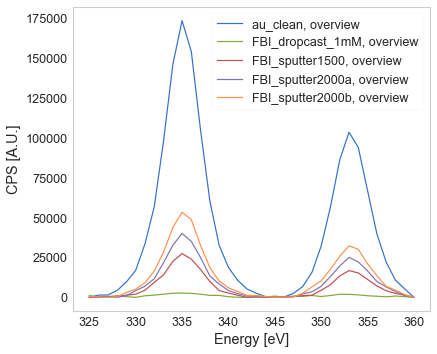

In [230]:
for xp in bg_exps:
    plot_region(xp, 'overview')
cosmetics_plot()

/Users/pabloherrero/anaconda3/envs/IC-3.7-2018-11-14/lib/python3.7/site-packages/numpy/core/fromnumeric.py:56: FutureWarning: 'argmin' is deprecated, use 'idxmin' instead. The behavior of 'argmin'
will be corrected to return the positional minimum in the future.
Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


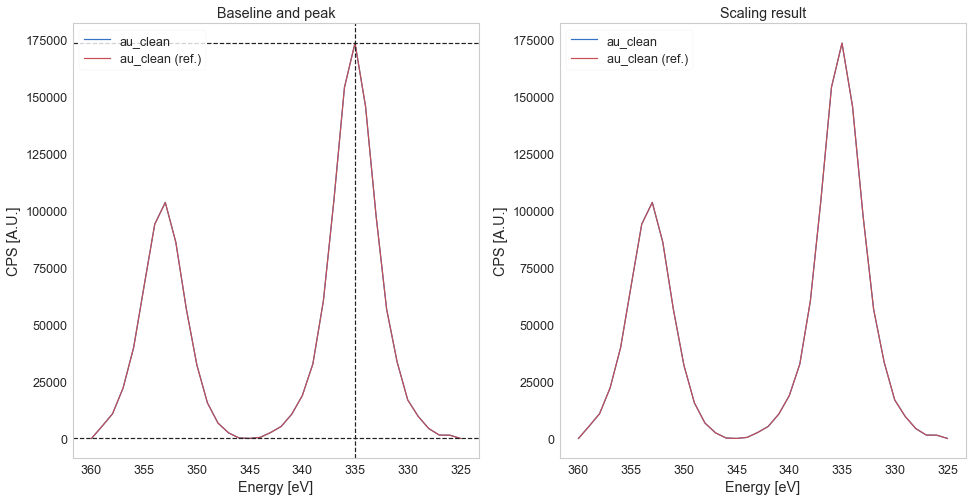

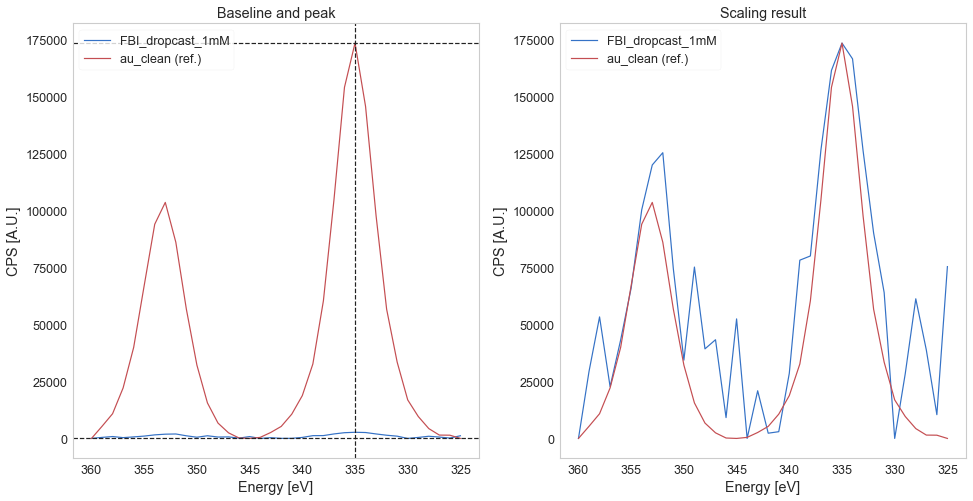

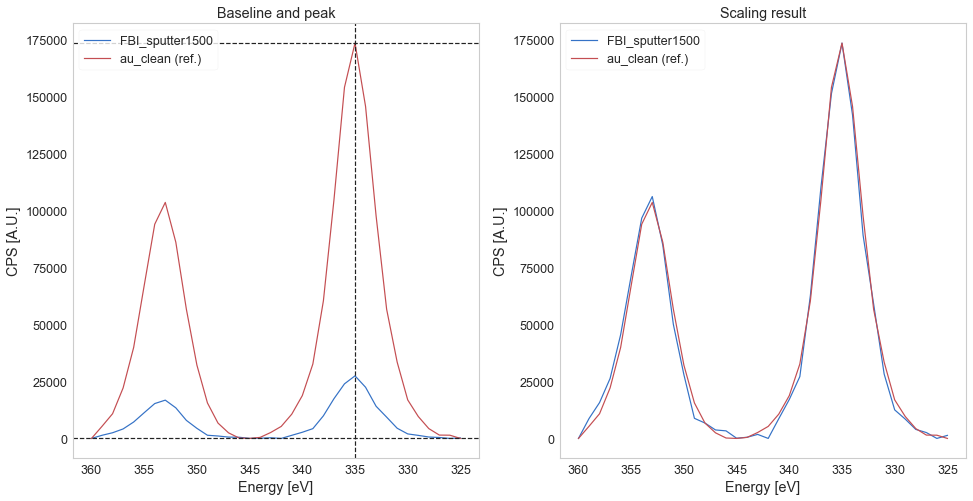

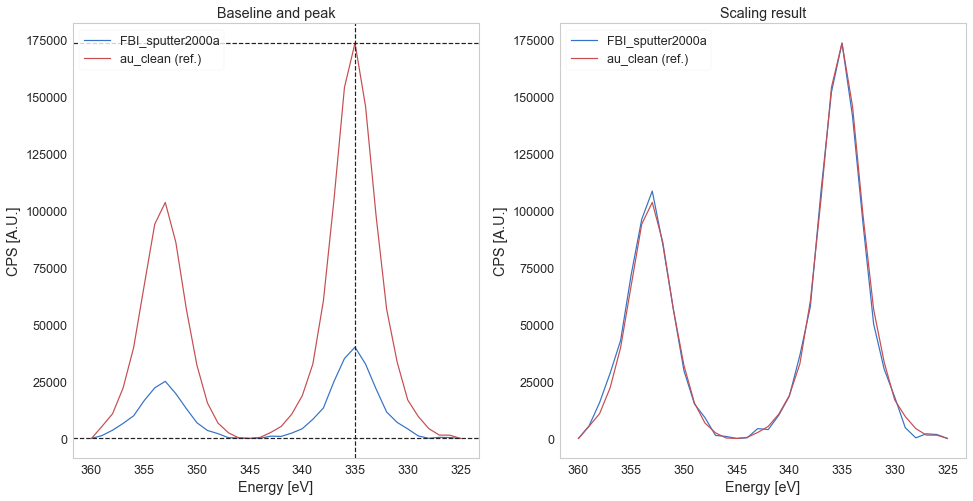

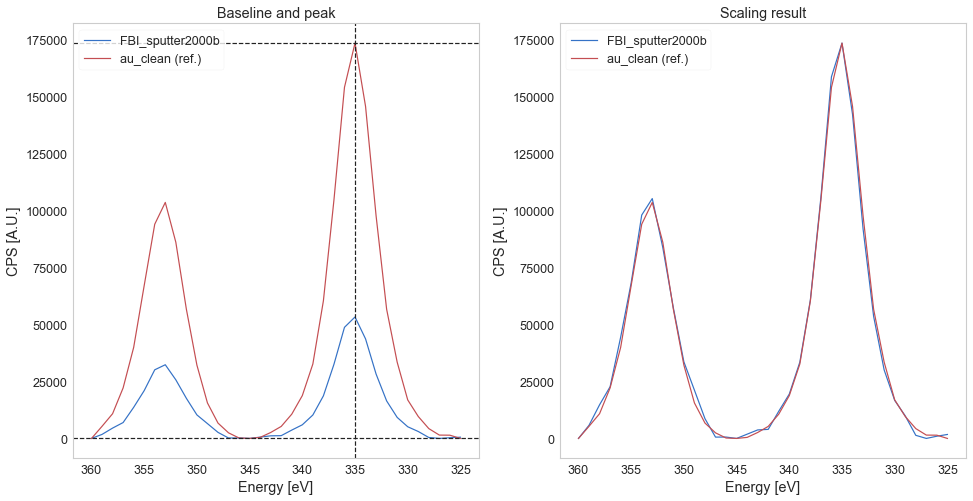

In [231]:
scaled_exps = []
for xpbg in bg_exps:
    scale = scale_and_plot_spectra(xp = xpbg, xpRef = bg_exps[0], region = 'overview')
    scaled_exps.append(scale_dfx(xp = xpbg, scale_factor = scale))

### Check scaling

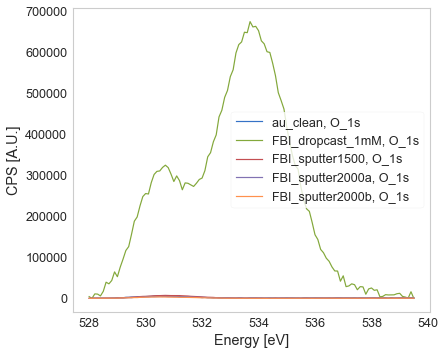

In [232]:
for xp in scaled_exps:
    plot_region(xp, 'O_1s')
cosmetics_plot()

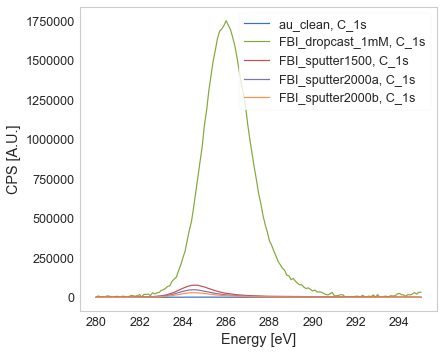

In [233]:
for xp in scaled_exps:
    plot_region(xp, 'C_1s')
cosmetics_plot()

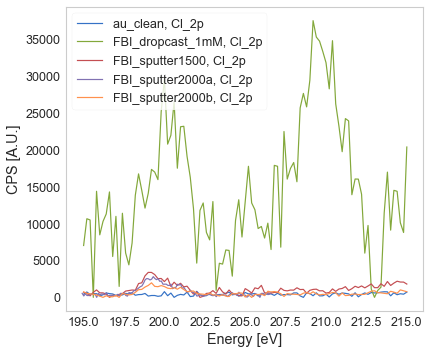

In [234]:
for xp in scaled_exps:
    plot_region(xp, 'Cl_2p')
cosmetics_plot()

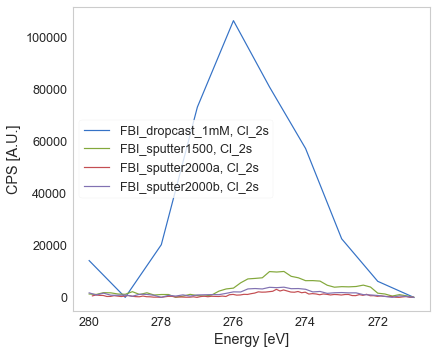

In [235]:
for xp in scaled_exps[1:]:
    plot_region(xp, 'Cl_2s')
cosmetics_plot()

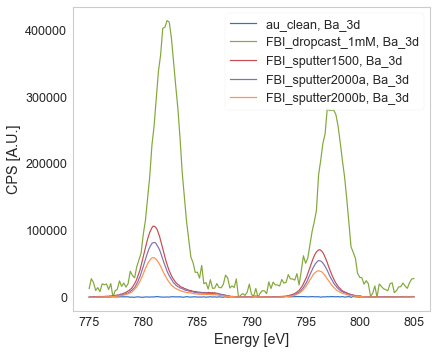

In [236]:
for xp in scaled_exps:
    plot_region(xp, 'Ba_3d')
cosmetics_plot()

## Store processed experiments

In [237]:
import os
for xp, xpProc in zip(experiments, scaled_exps):
    filepath, filename = os.path.split(xp.path)
    newpath = filepath + '/proc/'
    try:
        os.mkdir(newpath)
    except FileExistsError: pass
#     print(newpath + filename)
    write_processed_xp(newpath + filename, xpProc)